# On-sky data from Keck (2020): LiFT
- Trick images

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav
from astropy.io import fits
import time

from modules.Telescope import Telescope
from modules.Detector  import Detector
from modules.Source    import Source
from modules.Zernike   import Zernike
from modules.LIFT      import LIFT

from tools.misc import mask_circle
from tools.fit_gaussian import fitgaussian, gaussian

In [117]:
file1_path = r"C:\Users\rafae\OneDrive\Ambiente de Trabalho\On_sky_data_Keck\20200108_TRICK\20200108_TRICK\20200108lift_zc4_8x.sav"
file2_path = r"C:\Users\rafae\OneDrive\Ambiente de Trabalho\On_sky_data_Keck\20200108_TRICK\20200108_TRICK\20200108lift_zc4_4x.sav"

images_8_8 = True # if True we analyse the data with images 8*8

# Load the .sav file
if images_8_8 == True:
    data = readsav(file1_path)

else:
    data = readsav(file2_path)

# Print variable names
print("Variable names in the .sav file:", list(data.keys()))

cube = data["frame_cube"]
epochs = data["epoch"]

print(np.shape(cube))
print(np.shape(epochs))

# 21 different values of defocus offsets from -250 nm rms to +250 nm rms with a step value of 25 nm rms
# images from Trick with 8*8 pixels in case of file1 or 4*4 pixels in case of file2

defocus_values = np.arange(-250,+250+25,25)

print(defocus_values)
print(len(defocus_values))
print(defocus_values[10])

Variable names in the .sav file: ['frame_cube', 'epoch']
(21, 30, 8, 8)
()
[-250 -225 -200 -175 -150 -125 -100  -75  -50  -25    0   25   50   75
  100  125  150  175  200  225  250]
21
0


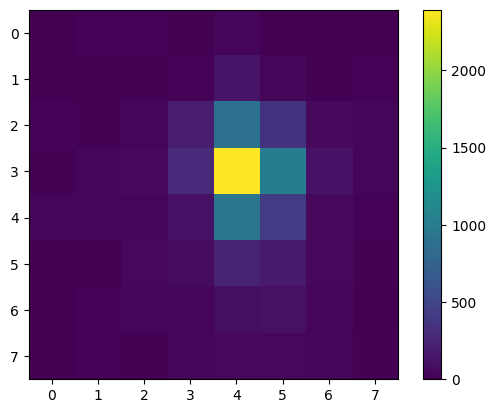

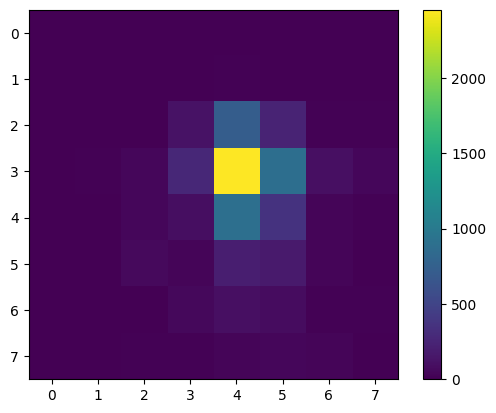

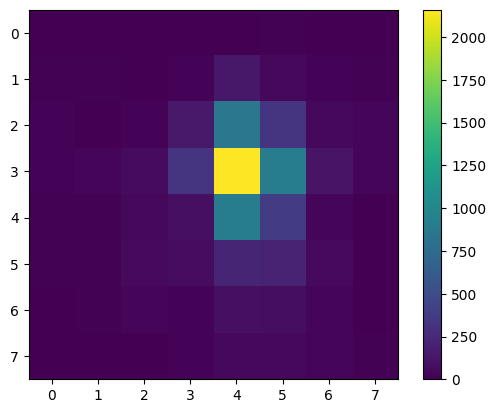

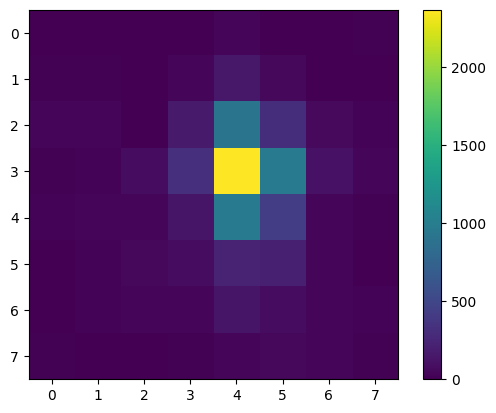

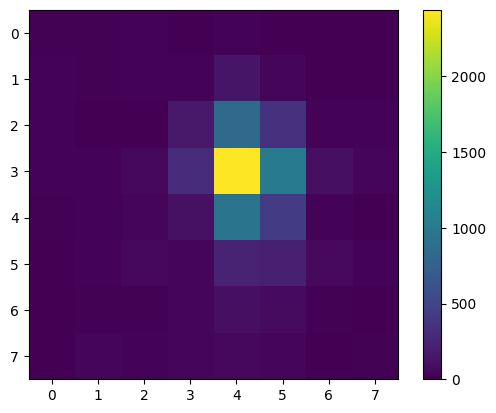

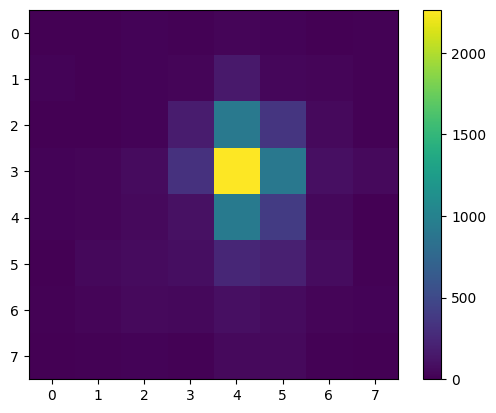

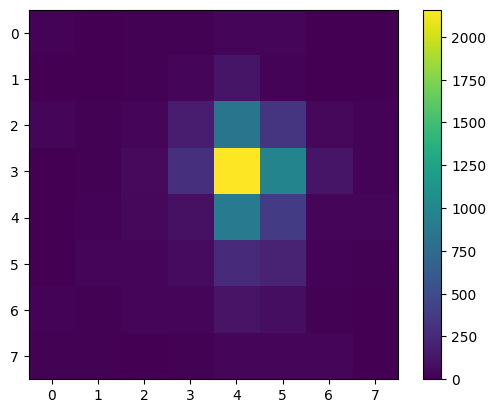

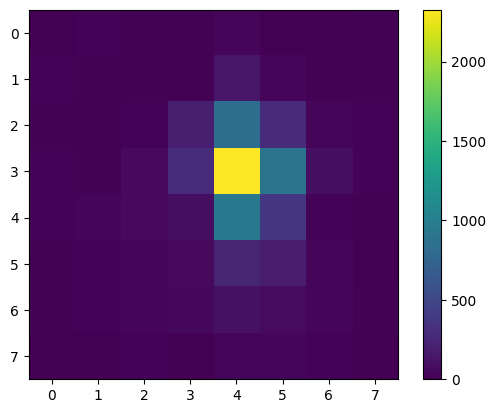

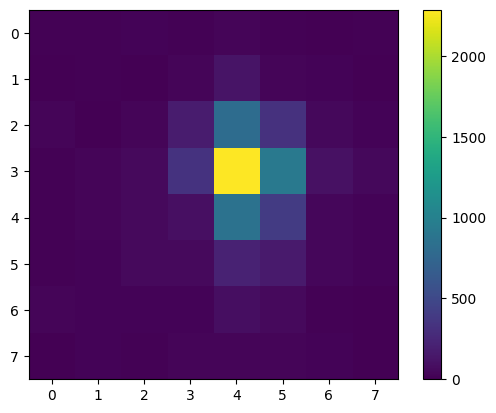

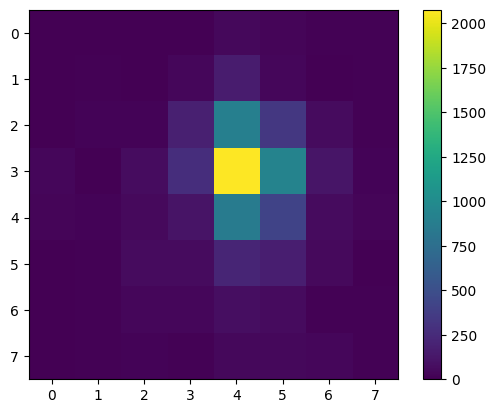

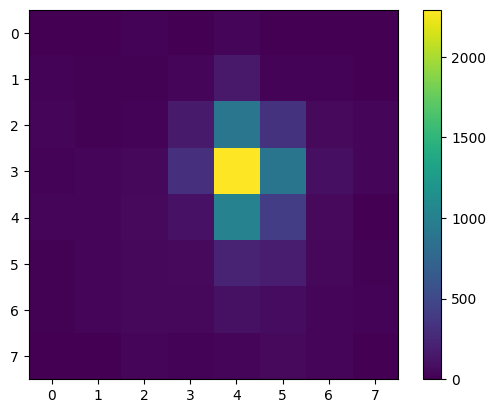

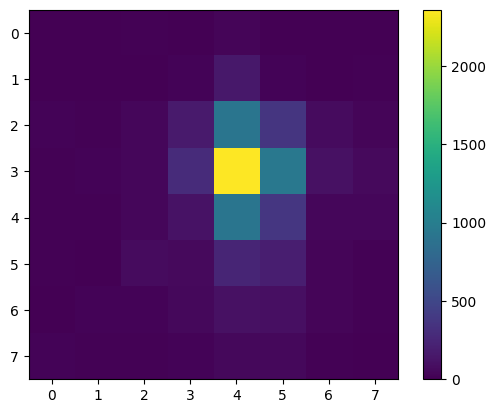

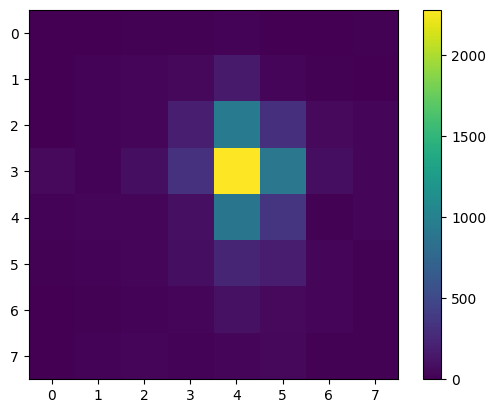

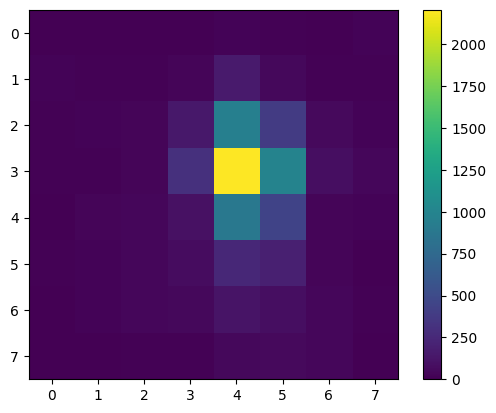

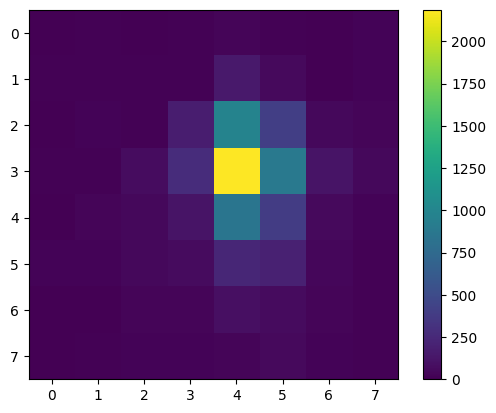

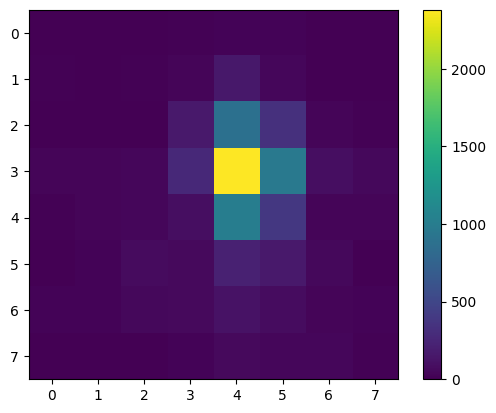

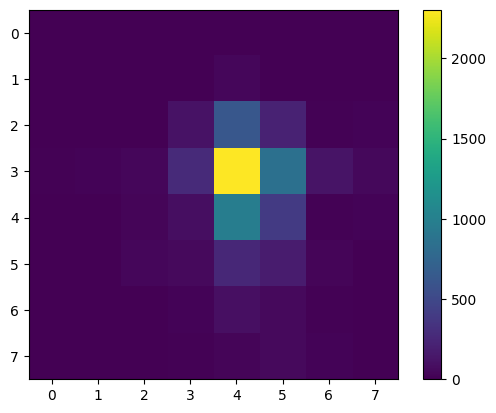

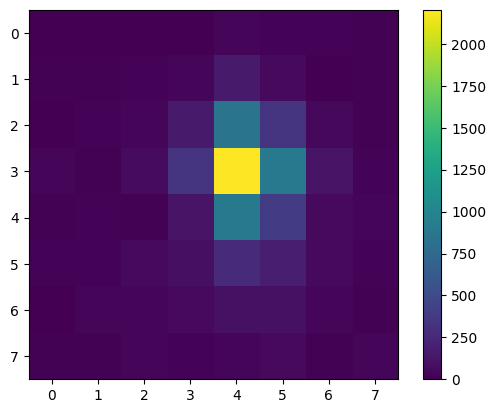

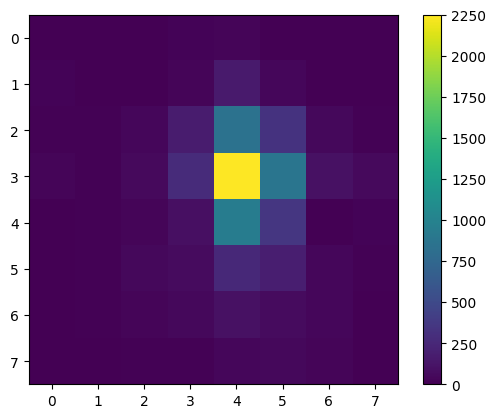

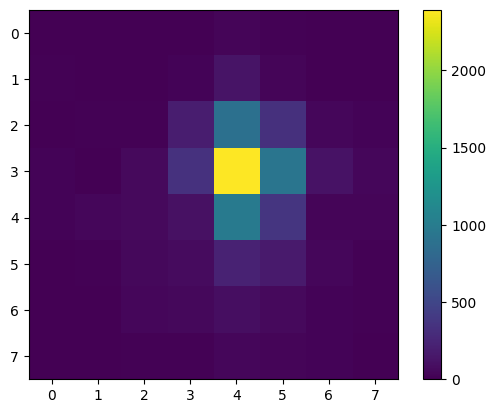

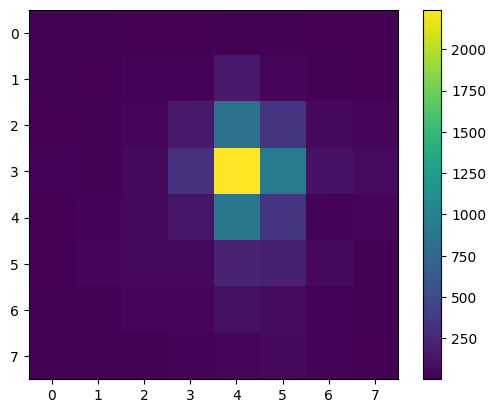

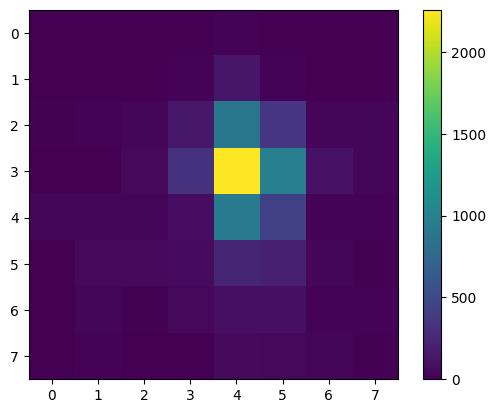

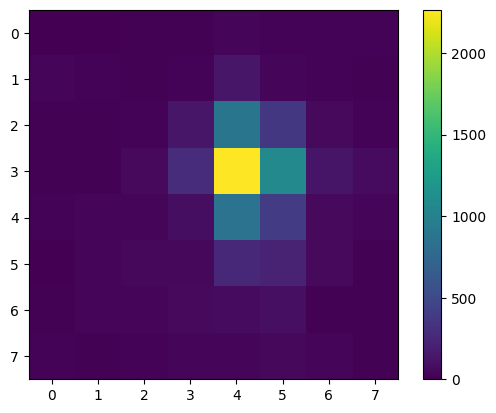

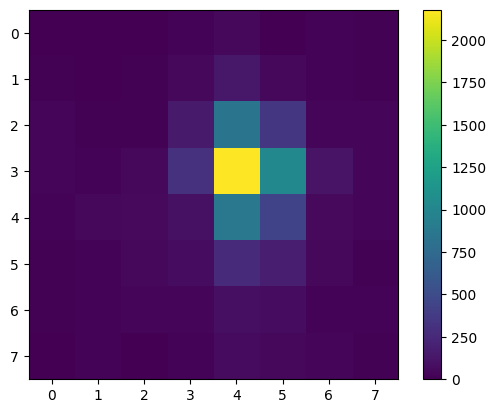

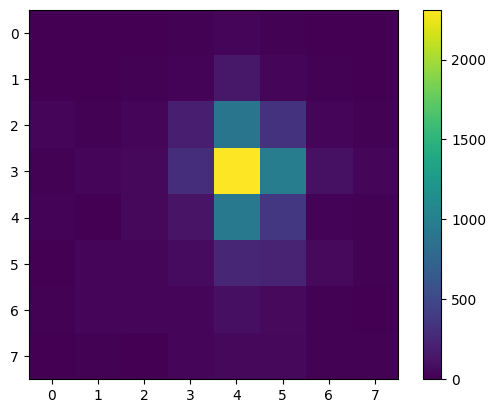

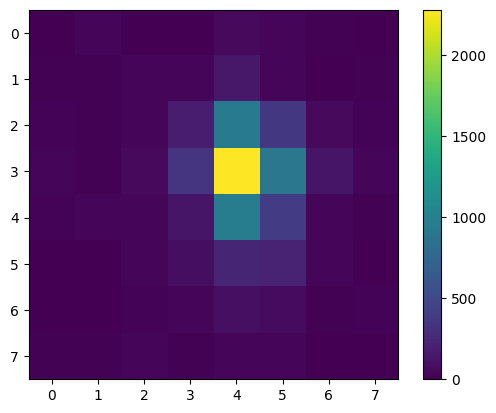

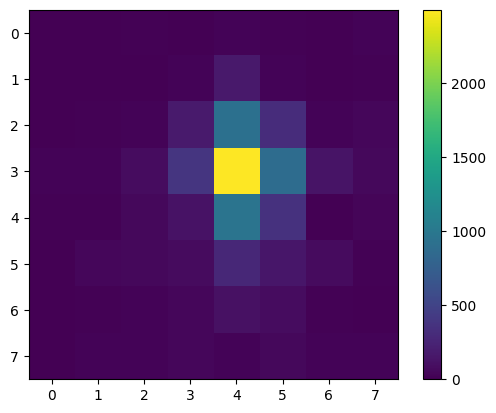

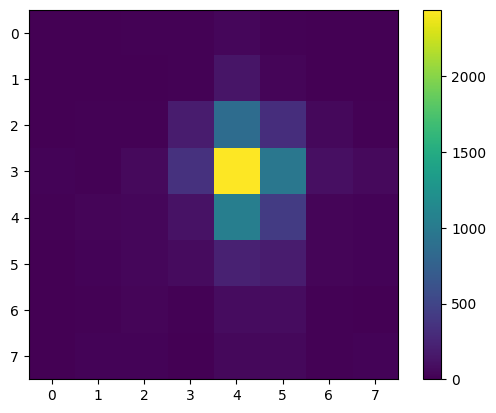

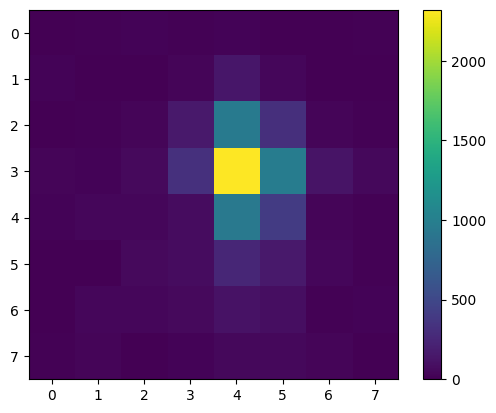

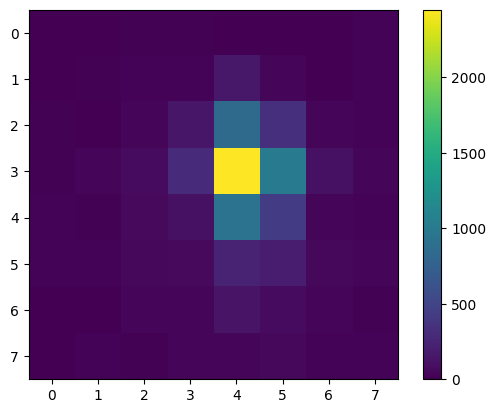

In [118]:
# plot of all Trick images for a given focus offset
for i in range(30):
    plt.imshow(cube[20,i,:,:])
    plt.colorbar()
    plt.show()

24.0


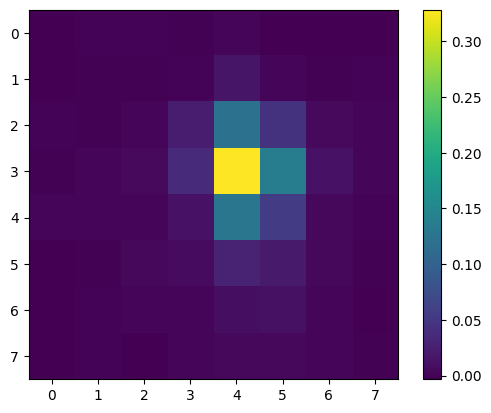

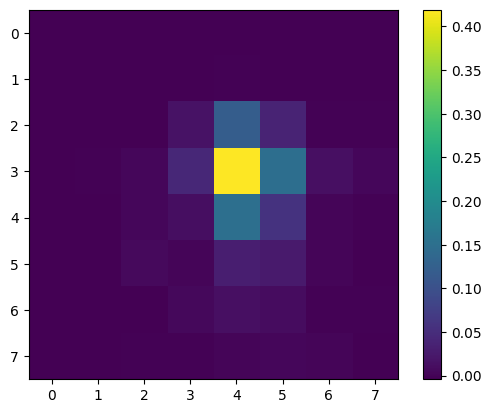

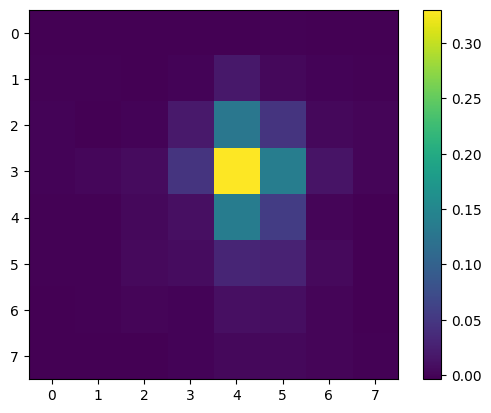

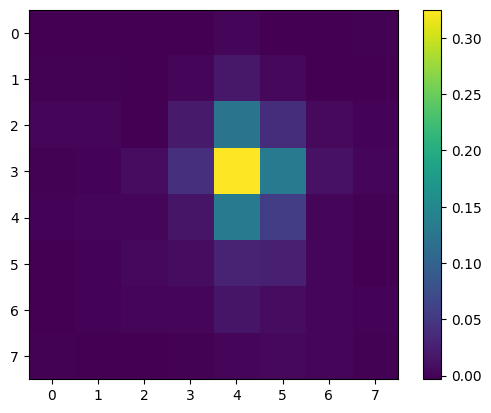

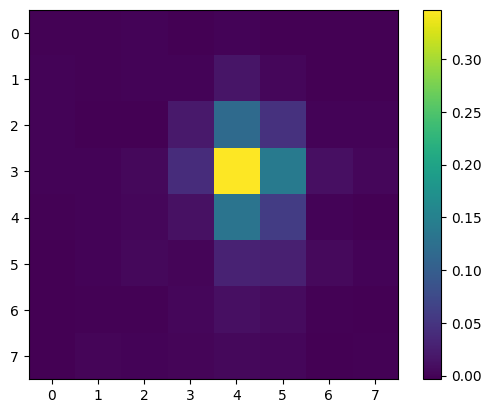

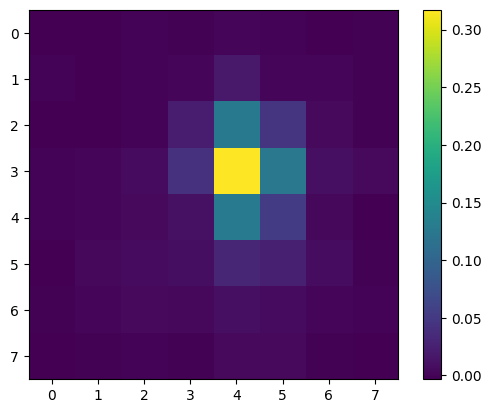

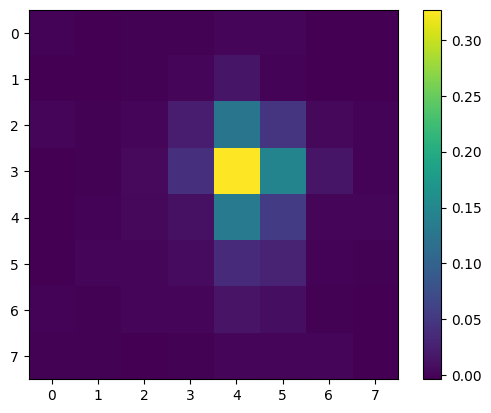

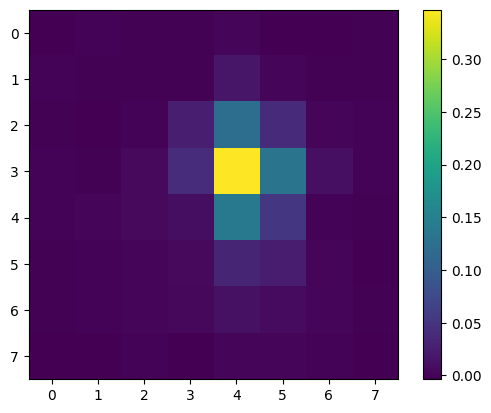

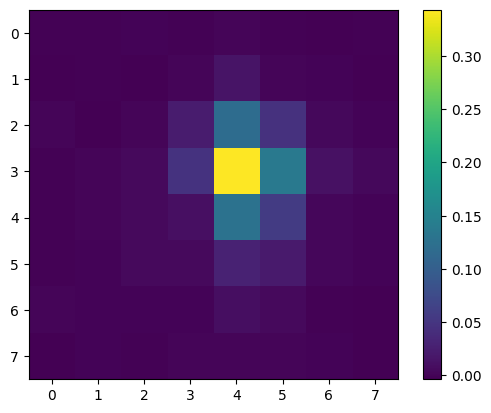

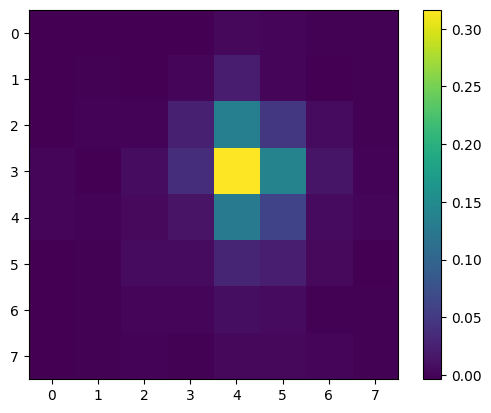

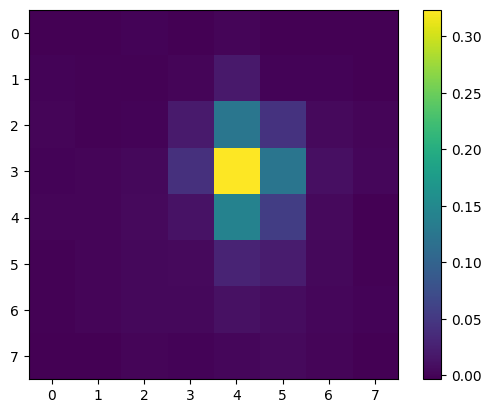

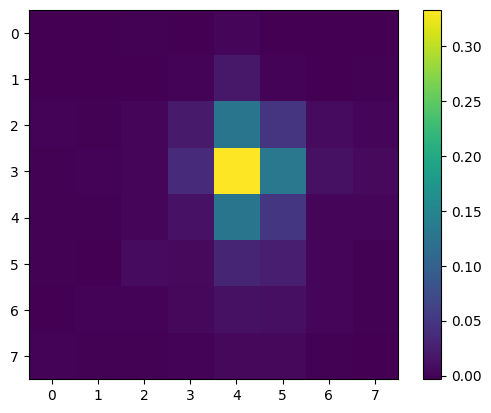

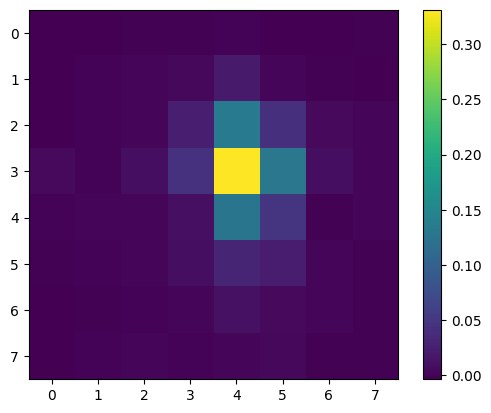

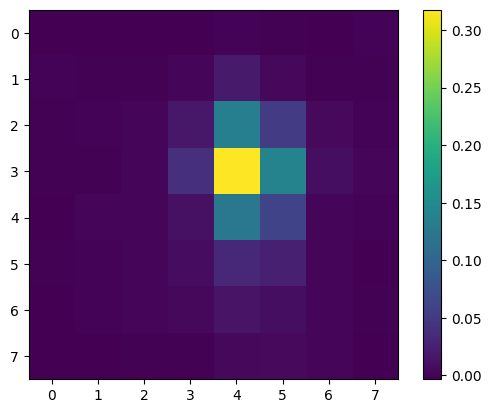

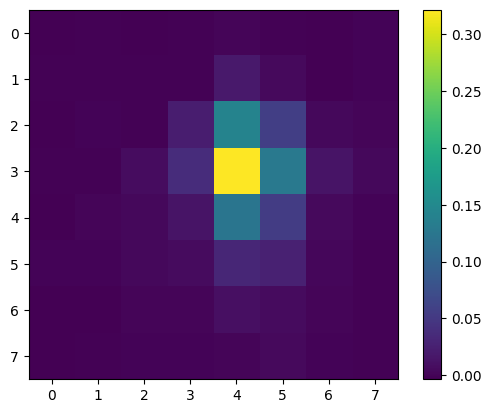

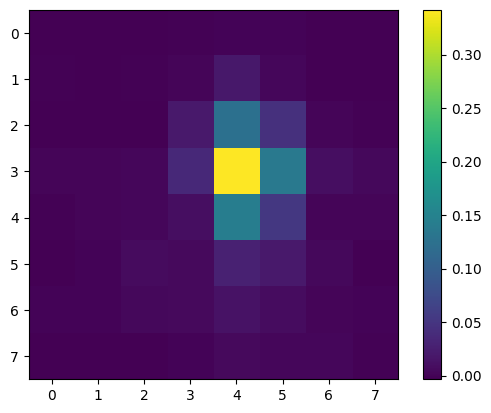

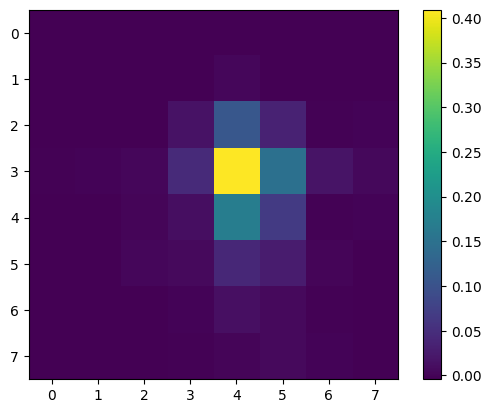

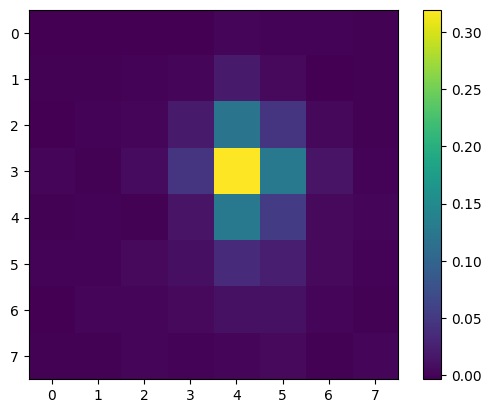

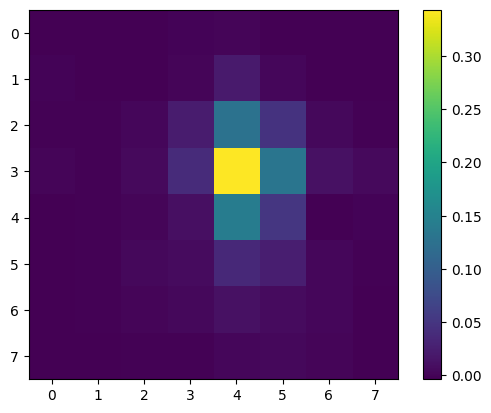

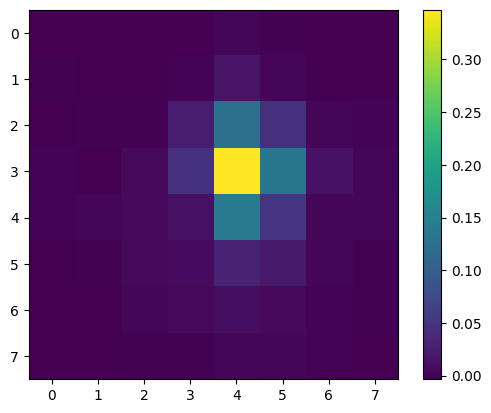

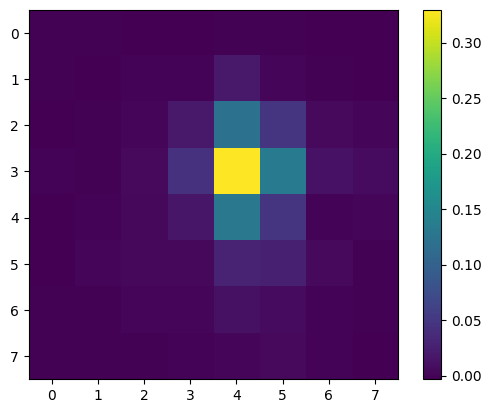

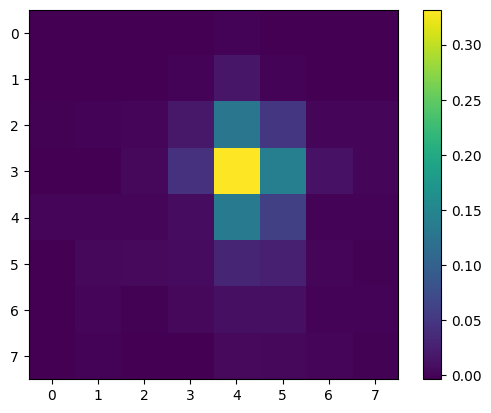

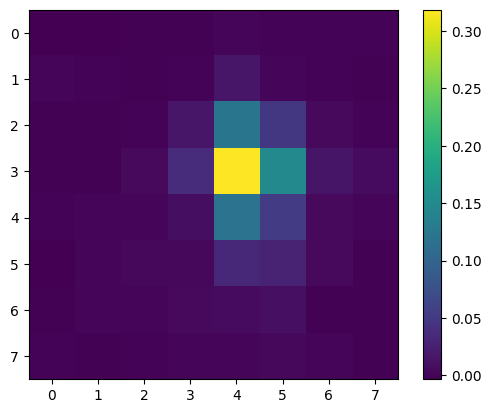

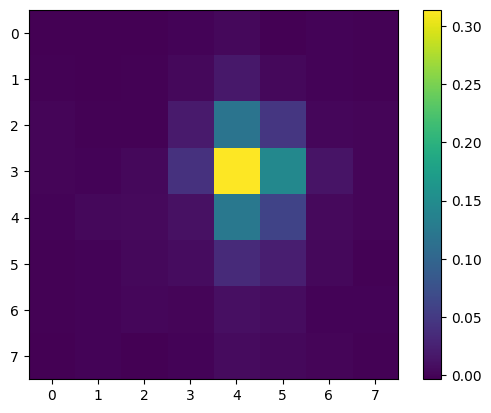

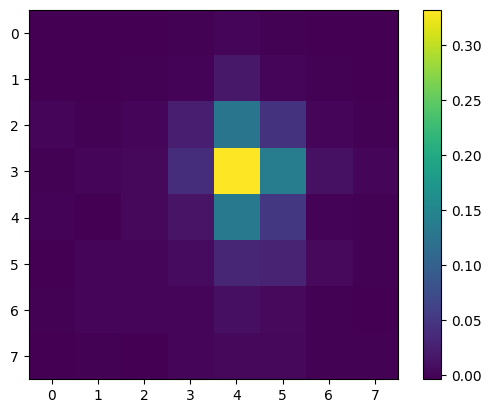

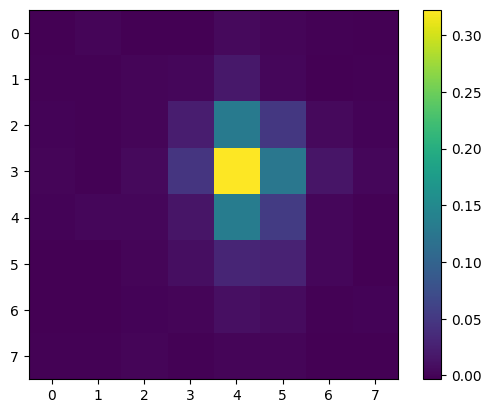

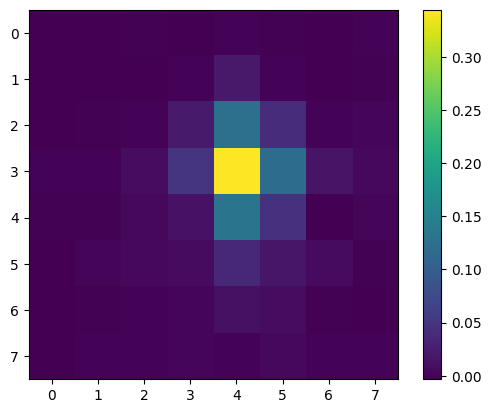

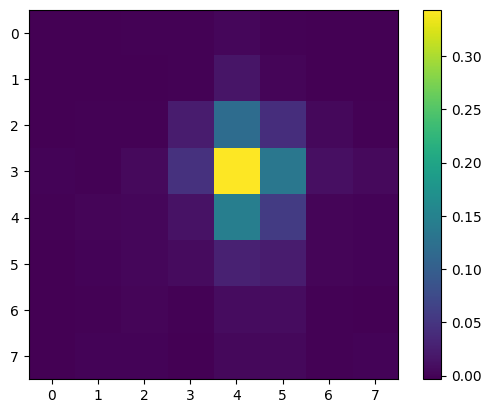

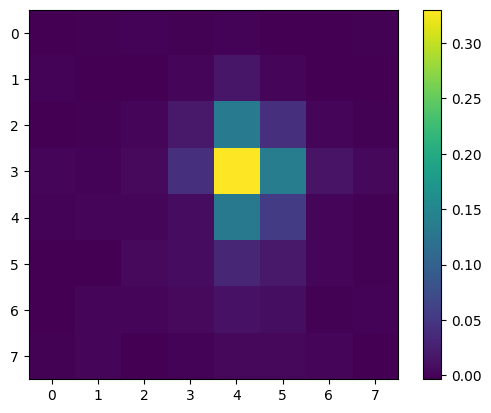

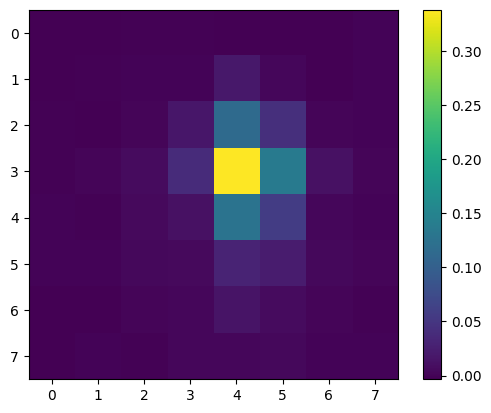

In [119]:
# remove background by subtracting the median value
print(np.median(cube))
cube = cube[:, :, :, :] - np.median(cube) # remove backround
cube /= np.sum(cube, axis=(-2,-1), keepdims=True) # Normalize the cube

# plot of all Trick images already pre-pocessed
for i in range(30):
    plt.imshow(cube[20,i,:,:])
    plt.colorbar()
    plt.show()

(21, 8, 8)
(21, 8, 8)


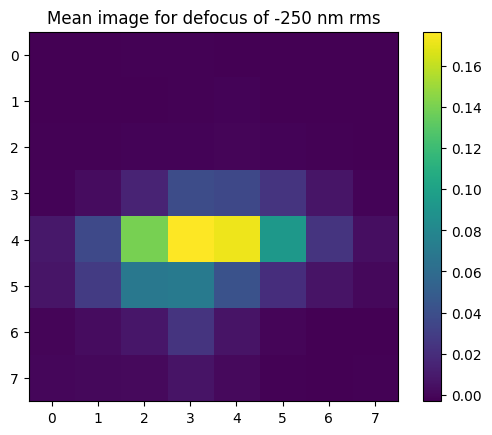

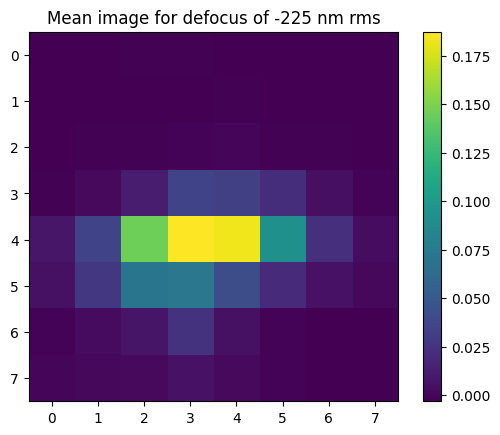

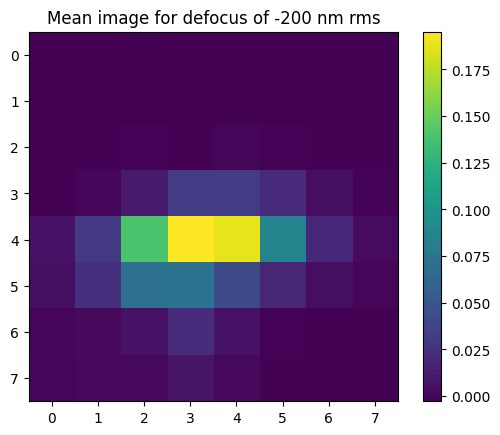

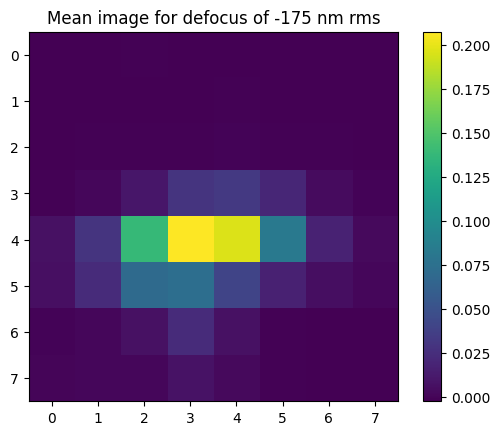

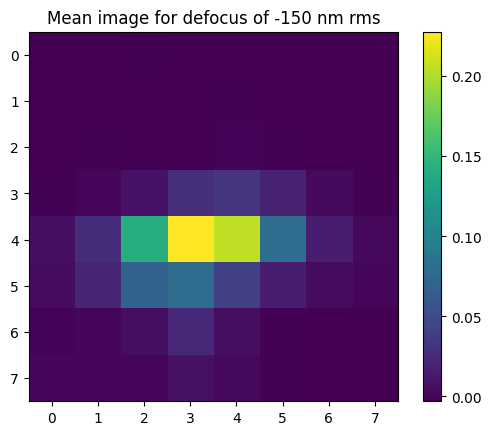

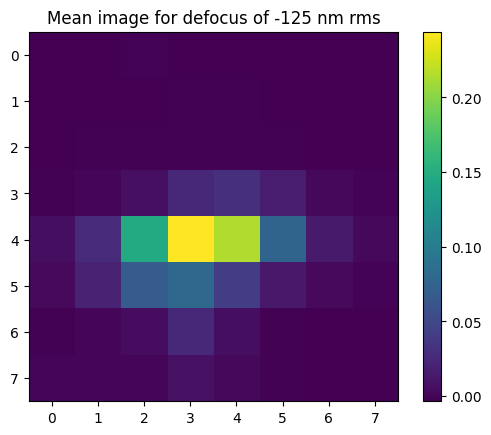

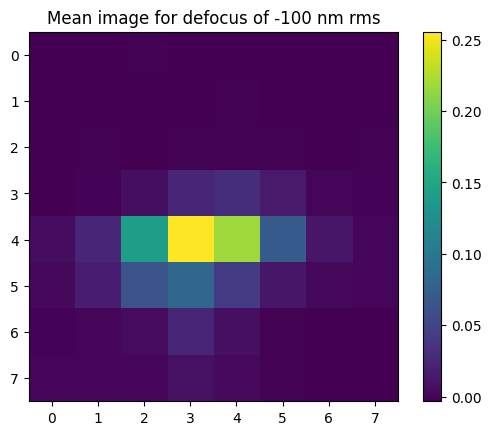

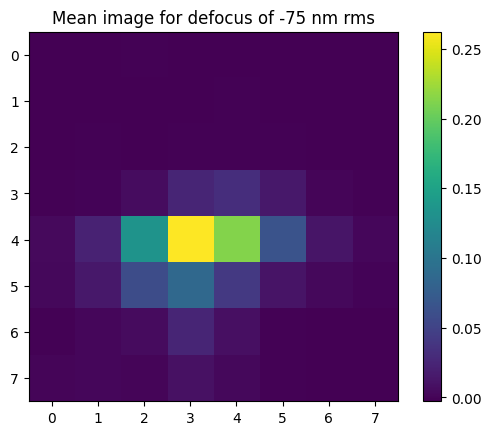

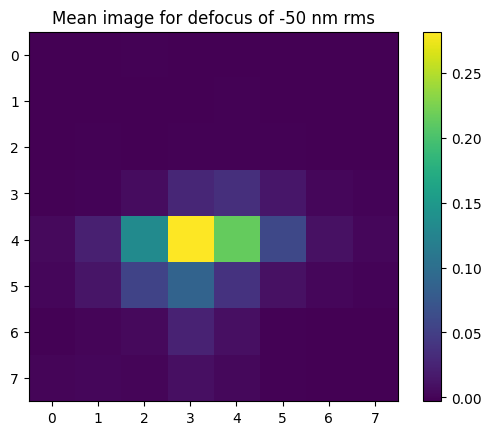

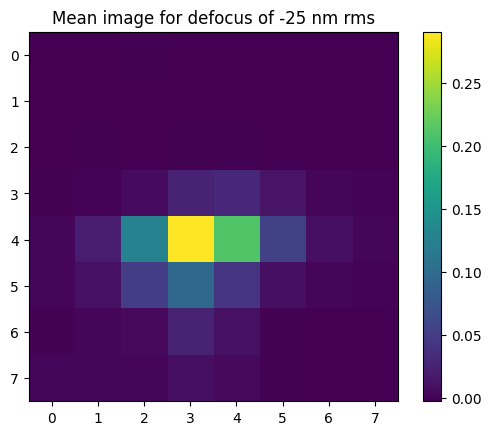

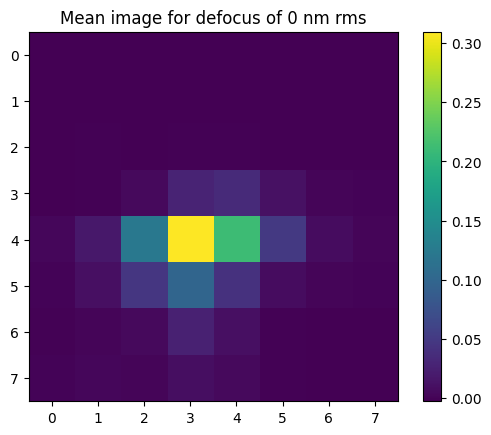

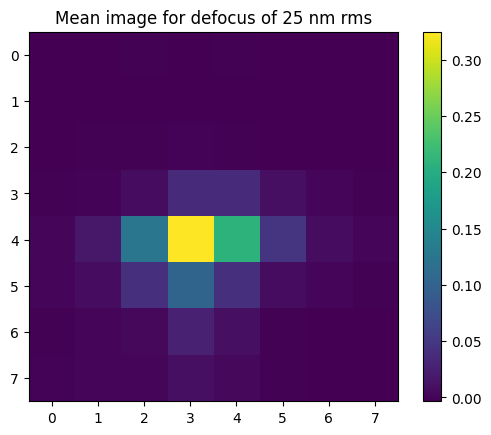

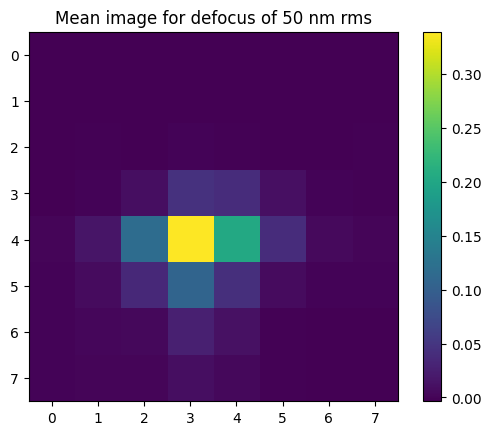

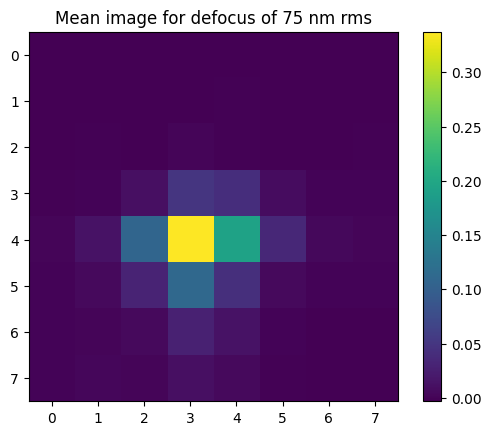

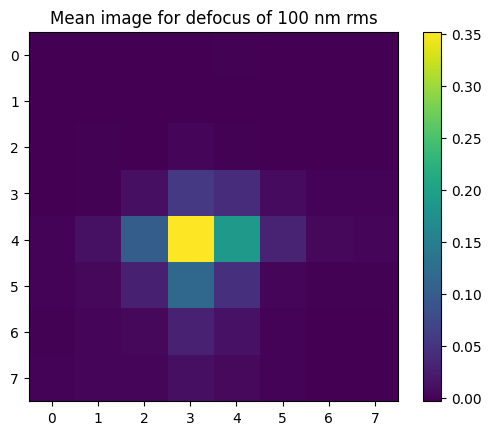

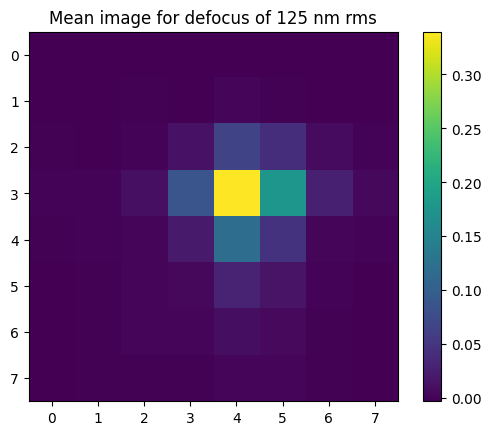

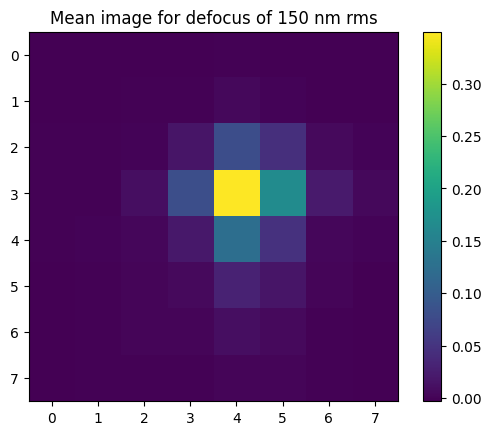

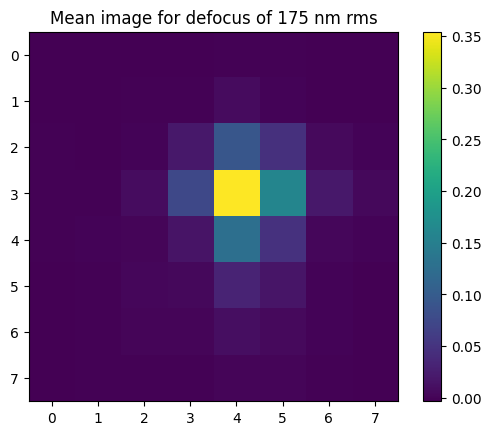

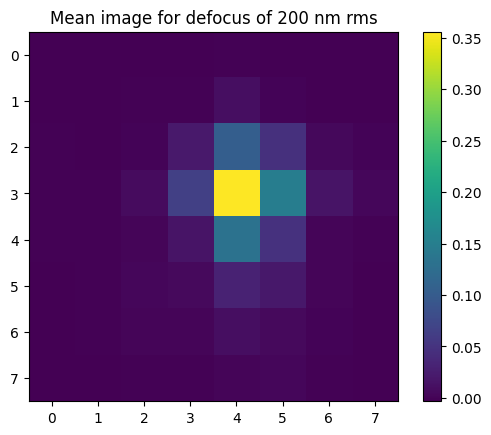

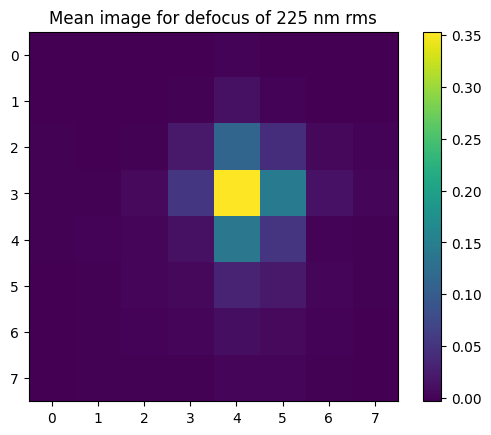

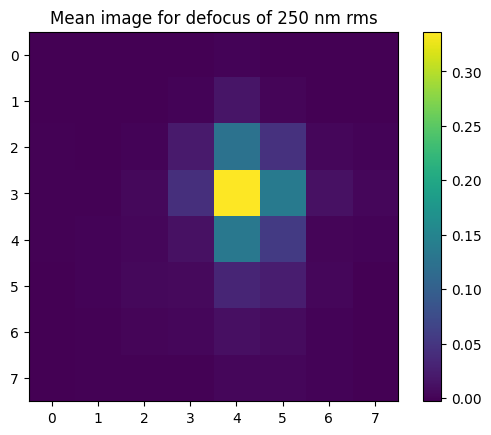

In [120]:
cube_mean = np.mean(cube,axis=1)
print(np.shape(cube_mean))

cube_var = np.var(cube,axis=1)
print(np.shape(cube_var))

# plot of the mean images for each defocus offset
for i in range(21):
    plt.imshow(cube_mean[i,:,:])
    plt.title("Mean image for defocus of {} nm rms".format(defocus_values[i]))
    plt.colorbar()
    plt.show()

In [121]:
# Define the path to the FITS file
fits_file_path = r'C:\Users\rafae\OneDrive\Ambiente de Trabalho\Pycharm_projects\FPWFS_master_thesis\Jupyter_notebooks\On_sky_Keck_tests\Pupil_Keck\keckPupil240x240px.fits'

# Read the FITS file
hdulist = fits.open(fits_file_path)

# Get the data from the primary HDU
keck_pupil = hdulist[0].data

# Get the header from the primary HDU
header = hdulist[0].header

# Close the FITS file
hdulist.close()

(slice(0, 8, None), slice(0, 8, None))
-------------------- TELESCOPE --------------------
Diameter 			11.732 	 [m]
Pupil sampling 			32 	 [pix]
------------------------------------------------


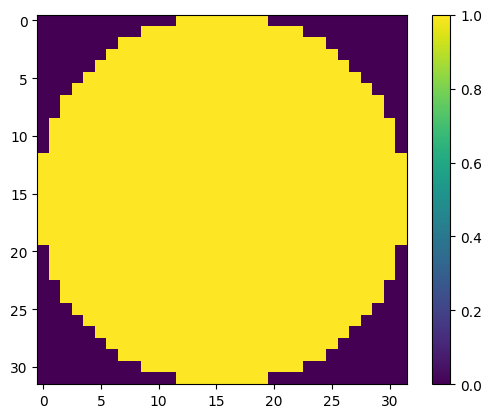

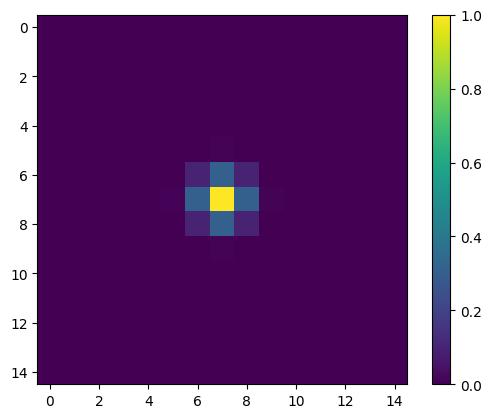

In [122]:
ang_pixel     = 50.0 # mas
sampling_time = 5e-3 # seconds
pixel_size    = 18e-6 # [m]

# Initialize the image cropper around the center
crop = 8
size = cube.shape[-1]
ROI = slice(size//2-crop//2-crop%2, size//2+crop//2)
ROI = (ROI, ROI)

print(ROI)

band = "K"

use_keck_pupil = False

if use_keck_pupil:
    keck = Telescope(img_resolution    = crop,
                 pupil             = mask_circle(len(keck_pupil), len(keck_pupil)/2, center=(0,0), centered=True), # a circular pupil is assumed
                 diameter          = 11.732,
                 focalLength       = pixel_size / ang_pixel * 206264806.71915,
                 pupilReflectivity = 1.0,
                 gpu_flag          = True)
    
    keck.pupil = keck_pupil

else:
    keck = Telescope(img_resolution    = crop,
                 pupil             = mask_circle(32, 16, center=(0,0), centered=True), # a circular pupil is assumed
                 diameter          = 11.732,
                 focalLength       = pixel_size / ang_pixel * 206264806.71915,
                 pupilReflectivity = 1.0,
                 gpu_flag          = True)
    
    
plt.imshow(keck.pupil)
plt.colorbar()
plt.show()

det = Detector(pixel_size    = pixel_size,
               sampling_time = sampling_time,
               samples       = 1,
               RON           = 4.0,
               QE            = 0.7)

ngs = Source([(band, 0.0)])
# ngs = Source([(band, 10.0)])
det * keck
ngs * keck

# Initialize dataset-dependent parameters
if band == 'K':
    sigma_obj = 0.65
    # modes = [0,1,2,3] # K PSFs seem to be slightly rotated, so we need to add astigmatism 
    modes = [0,1,2]
    elongation_def = lambda sigma_x, sigma_y: (sigma_x/sigma_y-1+0.1) * 750 * 0.8 # Ranther handcrafted expression for defocus estimation from PSF elongation
    # elongation_def = lambda sigma_x, sigma_y: (sigma_x/sigma_y-1+0.1) * 750 * 0.6 # with coefs for this specific on-sky data set

    #new formula tests:
    # elongation_def = lambda sigma_x, sigma_y: -(sigma_y/sigma_x) * 750 * 0.4 # with coefs for this specific on-sky data set
    
if band == 'H':
    sigma_obj = 0.4
    modes = [0,1,2]
    elongation_def = lambda sigma_x, sigma_y: (sigma_x/sigma_y-1+0.1) * 750 * 1.1

# Generate the convolution kernel, its role is to absorb the cross-talk between pixels
obj_resolution = 16
xx, yy = np.meshgrid(np.arange(0, obj_resolution), np.arange(0, obj_resolution))
obj1 = np.abs( gaussian(1.0, obj_resolution/2-1, obj_resolution/2-1,  sigma_obj, sigma_obj)(xx,yy) )
obj1 = obj1[:-1,:-1]
keck.object = cp.array(obj1) if keck.gpu else obj1 # Important! Initializethe convolution kernel

plt.imshow(obj1)
plt.colorbar()
plt.show()

# Initialize modal basis
Z = Zernike(modes_num=50)
Z.computeZernike(keck)

diversity_shift = 200e-9    
new_diversity = Z.Mode(4)*diversity_shift

## Diversity calibration with in-focus images

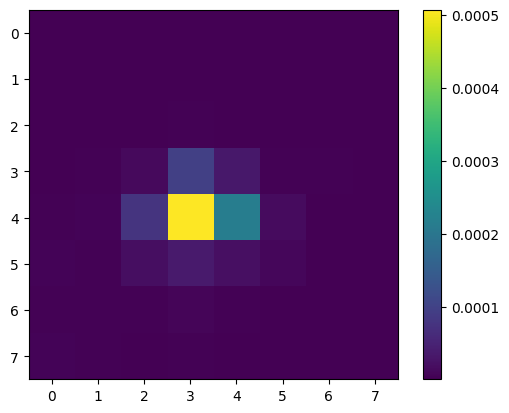

[ 4.5734973e-07 -2.0215953e-07 -9.6779310e-08]


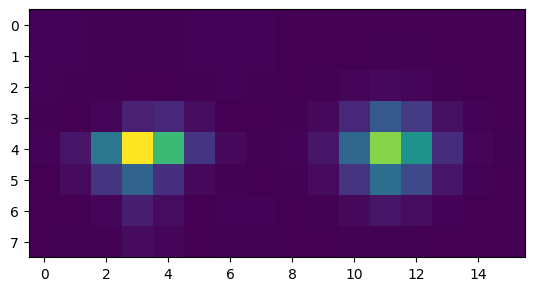

Expected defocus: 0.0 [nm]
Measured defocus -96.8 [nm]


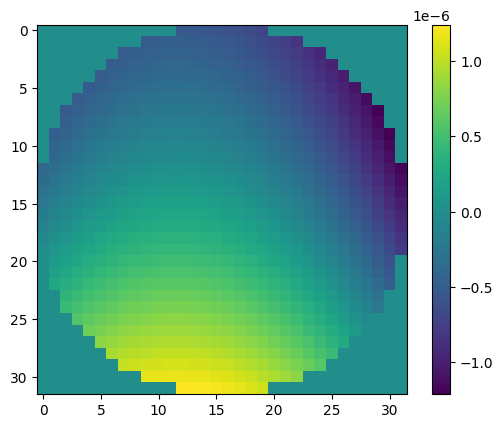

-9.677931e-08
[ 3.8438372e-09 -7.7862661e-10 -4.2543933e-09]


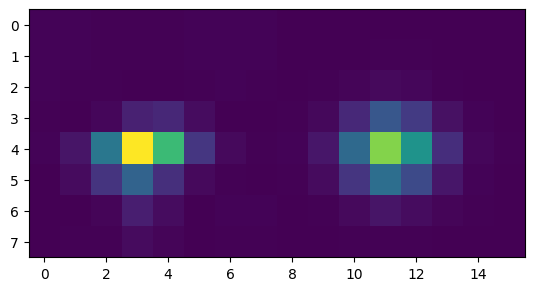

Expected defocus: 0.0 [nm]
Measured defocus -4.3 [nm]


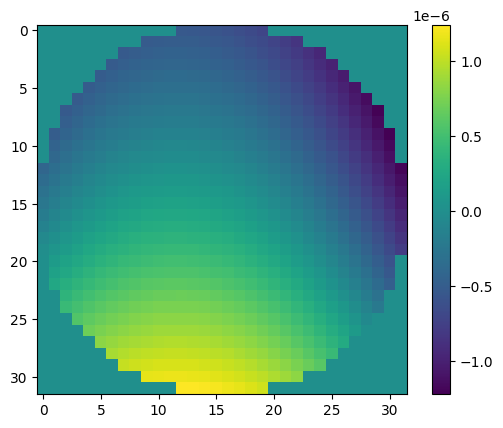

-4.2543933e-09
[-6.1558503e-10  2.5302729e-10  8.3235024e-10]


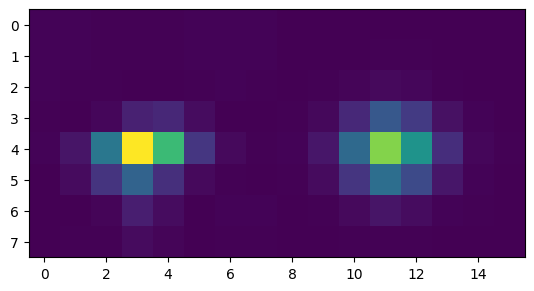

Expected defocus: 0.0 [nm]
Measured defocus 0.8 [nm]


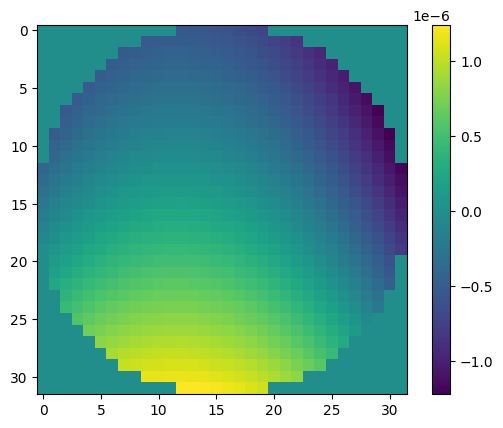

8.3235024e-10
[ 1.11049926e-10 -4.62221442e-11 -1.51671523e-10]


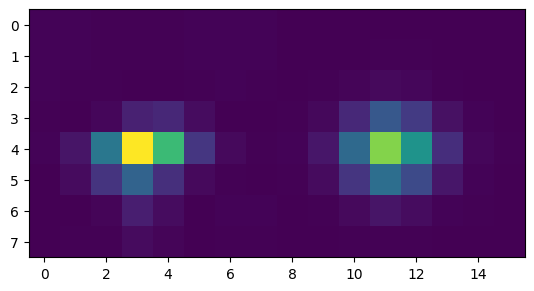

Expected defocus: 0.0 [nm]
Measured defocus -0.2 [nm]


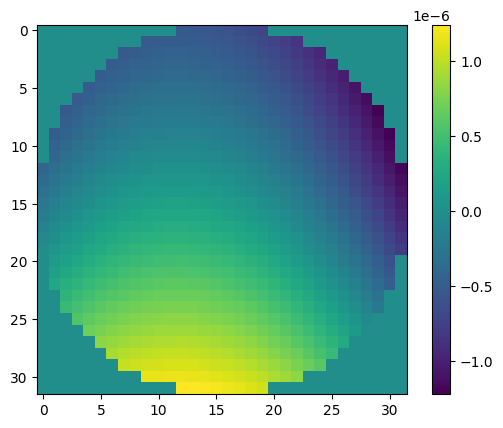

-1.5167152e-10
[-2.9342275e-11  1.2212230e-11  4.0045897e-11]


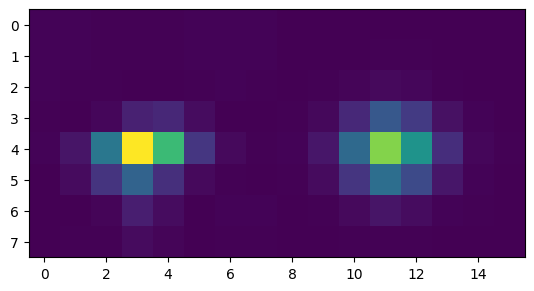

Expected defocus: 0.0 [nm]
Measured defocus 0.0 [nm]


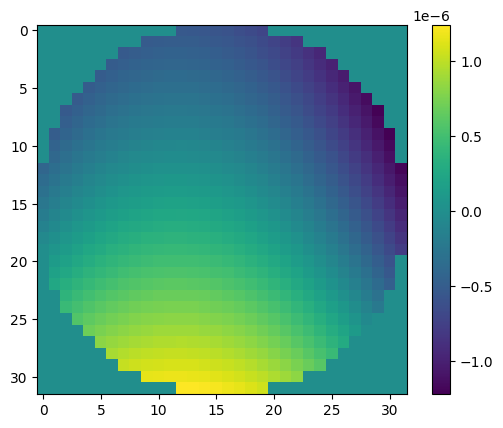

4.0045897e-11
[ 2.0877069e-11 -8.6895222e-12 -2.8493546e-11]


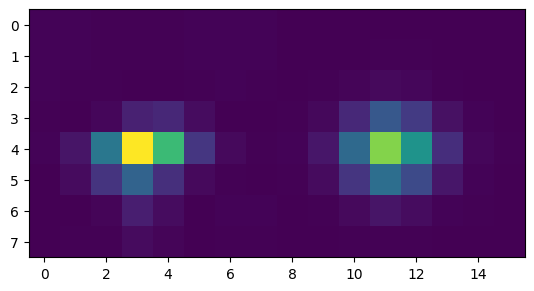

Expected defocus: 0.0 [nm]
Measured defocus -0.0 [nm]


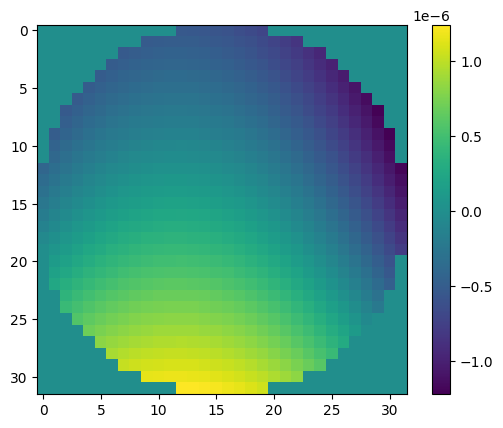

-2.8493546e-11
[-1.4855440e-11  6.1834505e-12  2.0274192e-11]


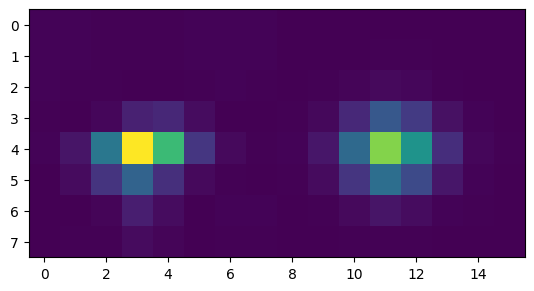

Expected defocus: 0.0 [nm]
Measured defocus 0.0 [nm]


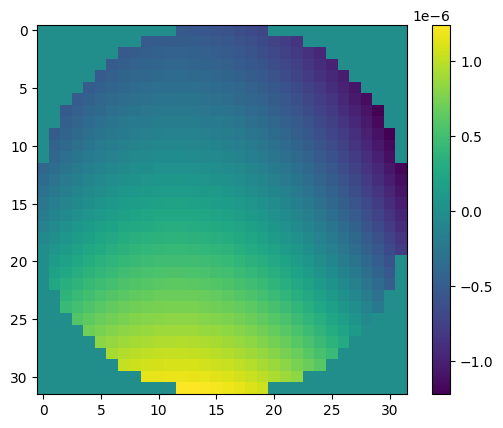

2.0274192e-11
[ 1.0569076e-11 -4.4006491e-12 -1.4427004e-11]


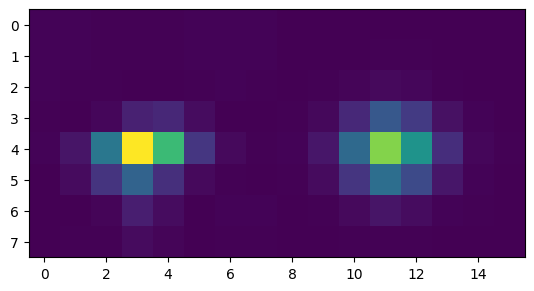

Expected defocus: 0.0 [nm]
Measured defocus -0.0 [nm]


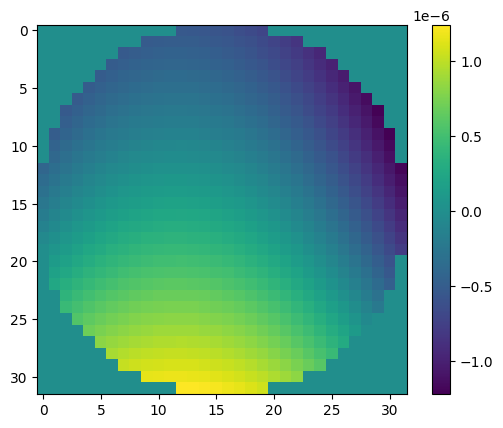

-1.4427004e-11
[-7.51935059e-12  3.13084237e-12  1.02652175e-11]


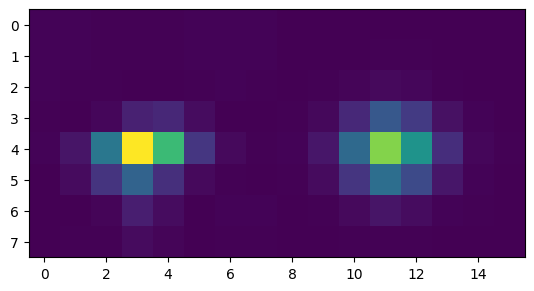

Expected defocus: 0.0 [nm]
Measured defocus 0.0 [nm]


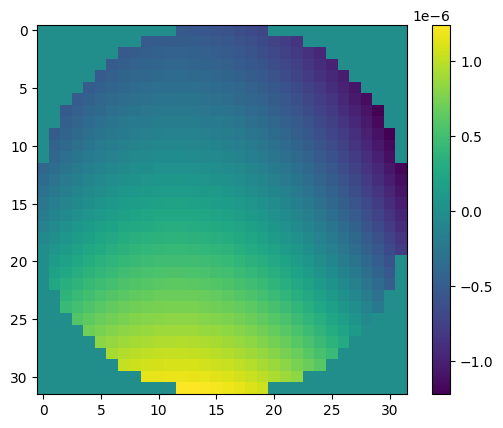

1.02652175e-11
[ 5.3512138e-12 -2.2265182e-12 -7.3031355e-12]


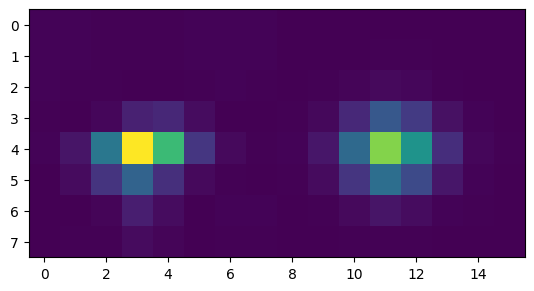

Expected defocus: 0.0 [nm]
Measured defocus -0.0 [nm]


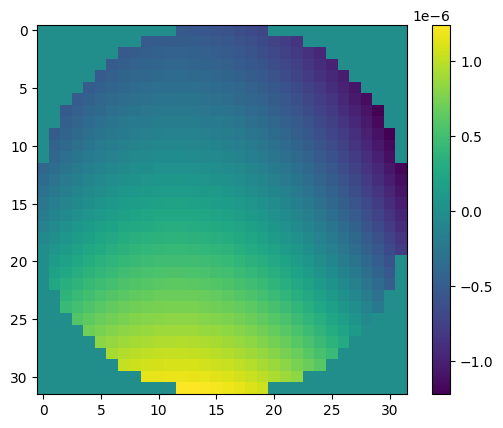

-7.3031355e-12
[-3.8094254e-12  1.5850147e-12  5.1963516e-12]


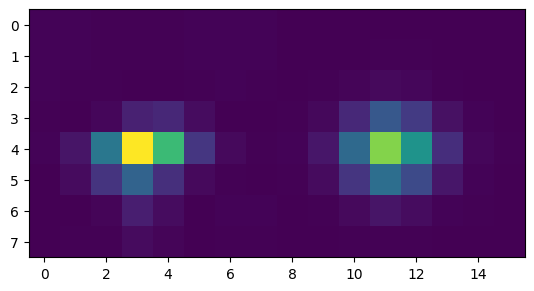

Expected defocus: 0.0 [nm]
Measured defocus 0.0 [nm]


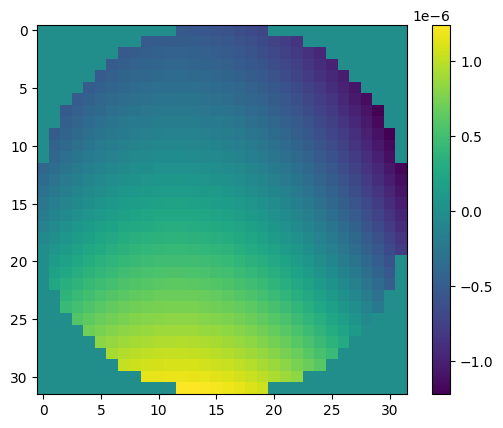

5.1963516e-12
[ 2.7109127e-12 -1.1270197e-12 -3.6968783e-12]


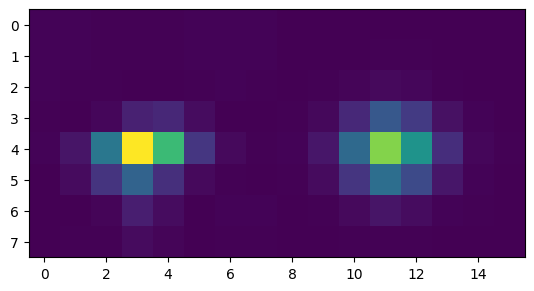

Expected defocus: 0.0 [nm]
Measured defocus -0.0 [nm]


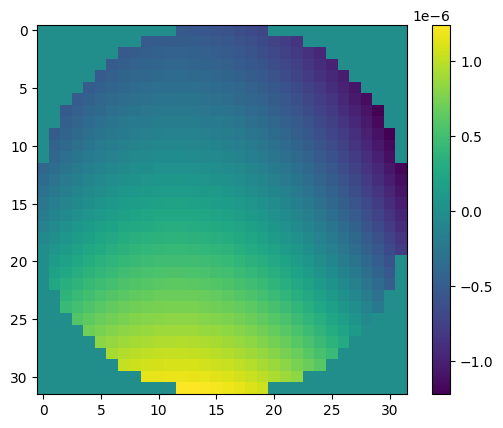

-3.6968783e-12
[-1.9296398e-12  8.0349540e-13  2.6309417e-12]


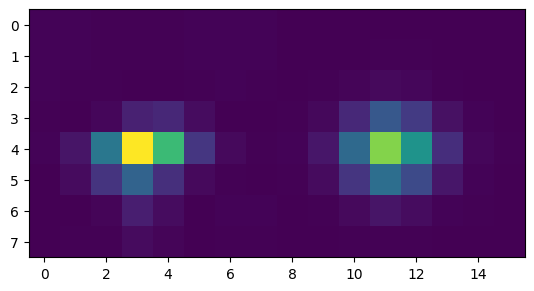

Expected defocus: 0.0 [nm]
Measured defocus 0.0 [nm]


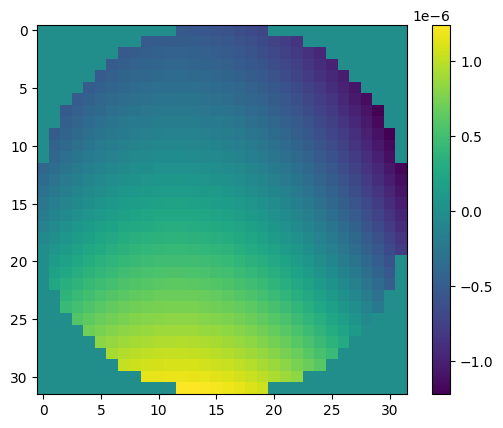

2.6309417e-12
[ 1.3697669e-12 -5.7404699e-13 -1.8725074e-12]


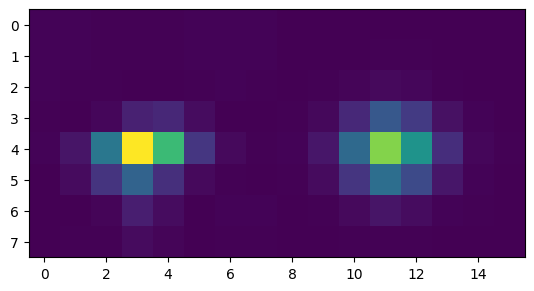

Expected defocus: 0.0 [nm]
Measured defocus -0.0 [nm]


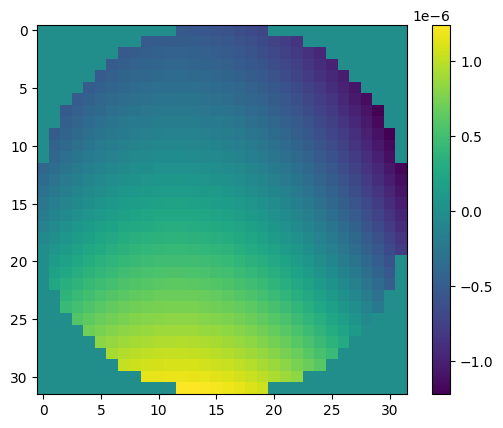

-1.8725074e-12
[-9.7028613e-13  4.0601355e-13  1.3300662e-12]


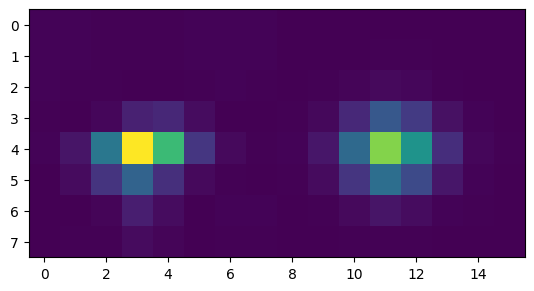

Expected defocus: 0.0 [nm]
Measured defocus 0.0 [nm]


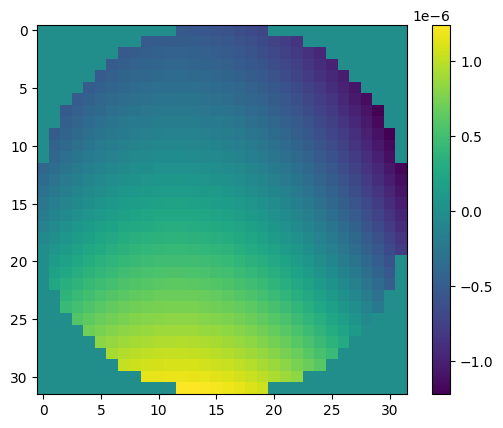

1.3300662e-12
[ 6.8990408e-13 -2.8632692e-13 -9.4339499e-13]


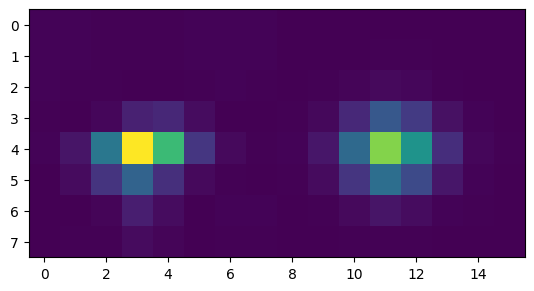

Expected defocus: 0.0 [nm]
Measured defocus -0.0 [nm]


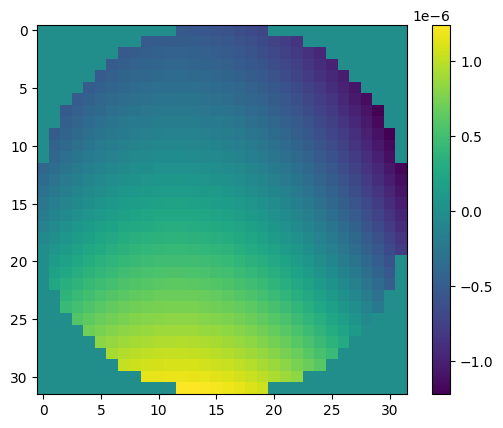

-9.43395e-13
[-4.9181964e-13  2.0098070e-13  6.6974020e-13]


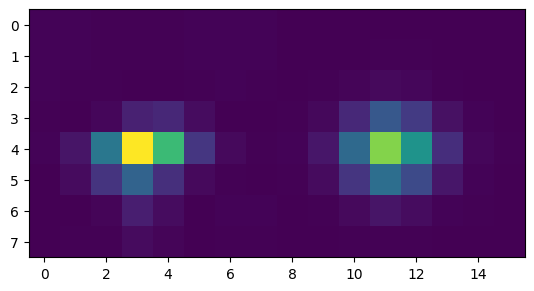

Expected defocus: 0.0 [nm]
Measured defocus 0.0 [nm]


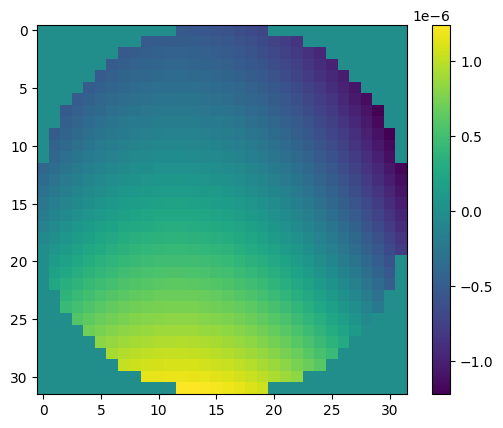

6.697402e-13
[ 3.4834332e-13 -1.4210772e-13 -4.7472340e-13]


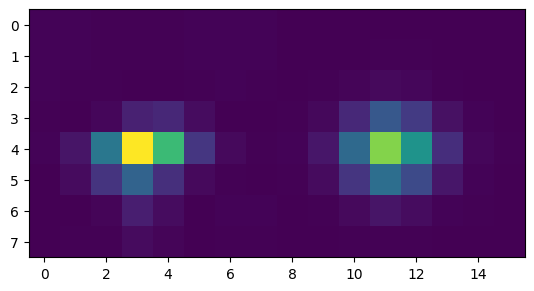

Expected defocus: 0.0 [nm]
Measured defocus -0.0 [nm]


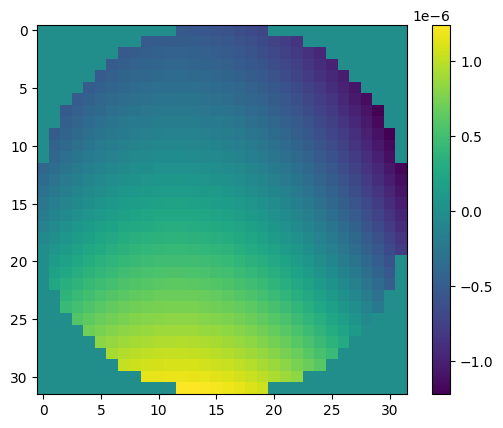

-4.747234e-13
[-2.4517790e-13  1.0319158e-13  3.3537333e-13]


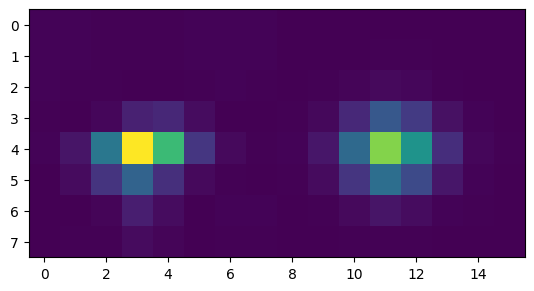

Expected defocus: 0.0 [nm]
Measured defocus 0.0 [nm]


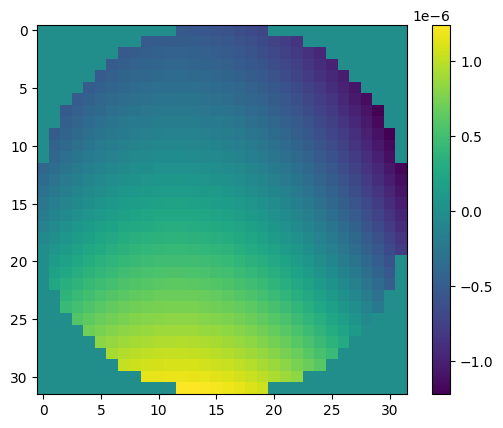

3.3537333e-13
[ 1.7248150e-13 -7.3370129e-14 -2.3849263e-13]


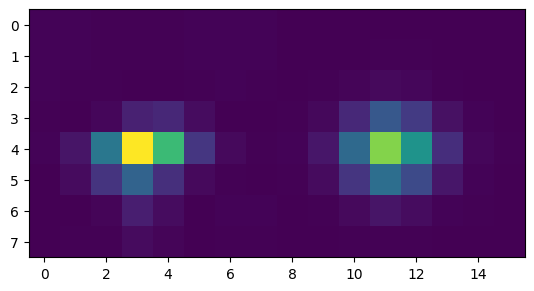

Expected defocus: 0.0 [nm]
Measured defocus -0.0 [nm]


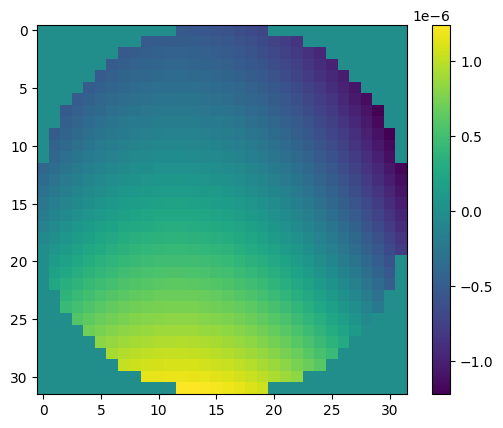

-2.3849263e-13
[-1.2858159e-13 -2.8176517e-14  1.6598574e-13]


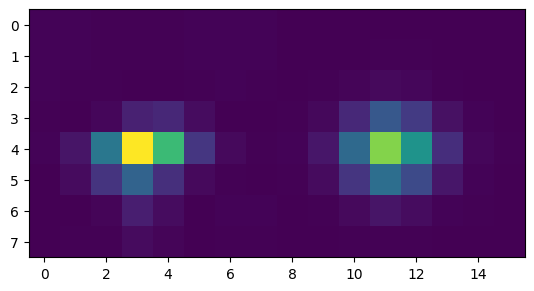

Expected defocus: 0.0 [nm]
Measured defocus 0.0 [nm]


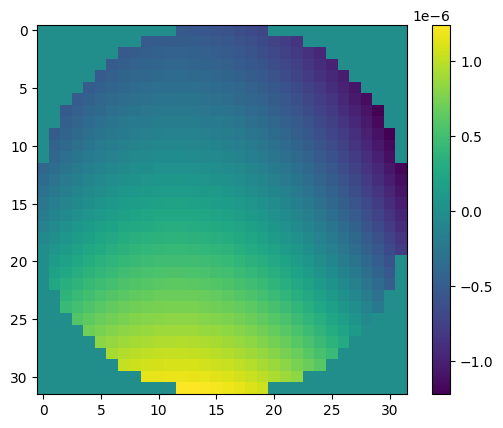

1.6598574e-13
[ 9.2291998e-14 -5.9873764e-14 -1.1641481e-13]


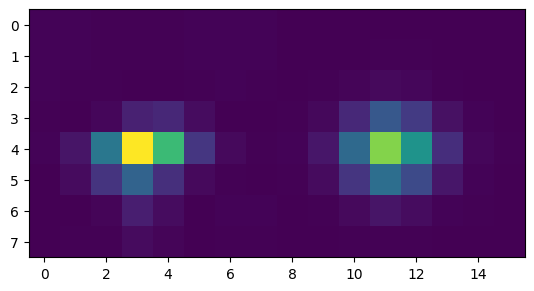

Expected defocus: 0.0 [nm]
Measured defocus -0.0 [nm]


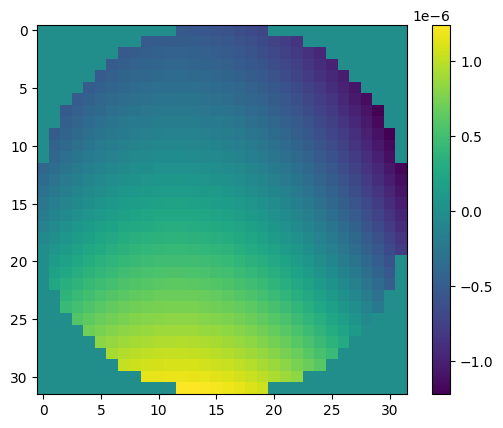

-1.1641481e-13
[ 6.4218663e-14 -2.6380589e-14  6.5626432e-14]


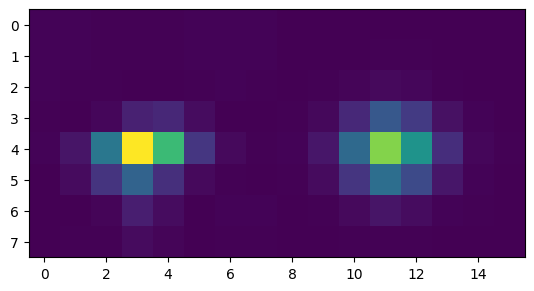

Expected defocus: 0.0 [nm]
Measured defocus 0.0 [nm]


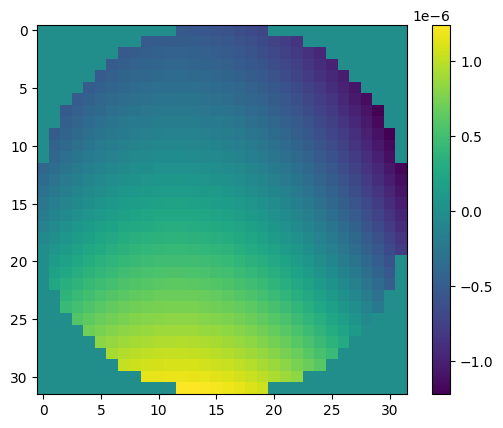

6.562643e-14
[ 6.4218663e-14 -2.6380589e-14  6.5626432e-14]


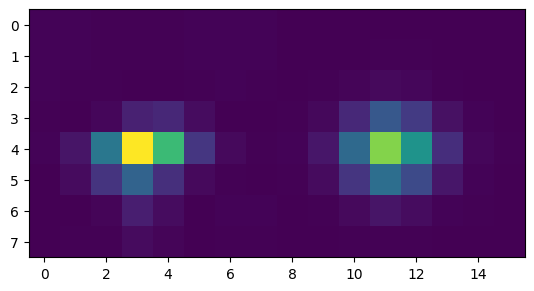

Expected defocus: 0.0 [nm]
Measured defocus 0.0 [nm]


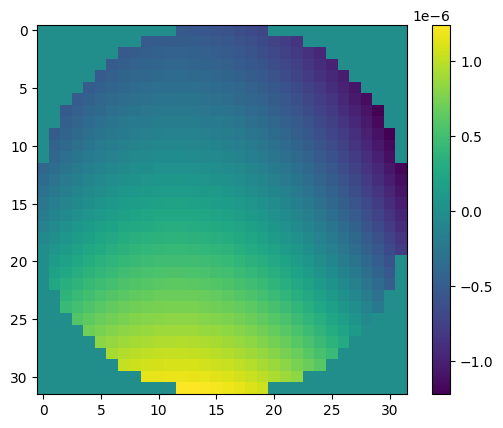

6.562643e-14
[ 6.4218663e-14 -2.6380589e-14  6.5626432e-14]


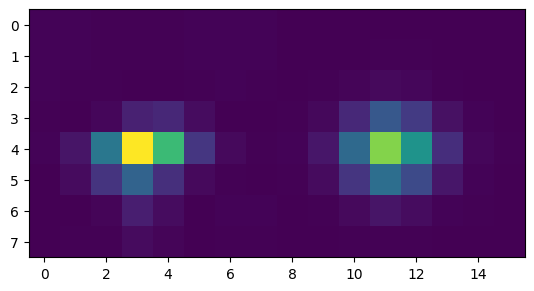

Expected defocus: 0.0 [nm]
Measured defocus 0.0 [nm]


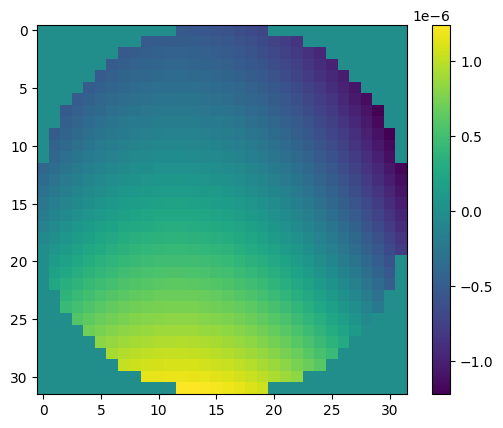

6.562643e-14
[[ 0.00000000e+00 -0.00000000e+00 -9.67793099e-08]
 [ 0.00000000e+00 -0.00000000e+00 -4.25439328e-09]
 [-0.00000000e+00  0.00000000e+00  8.32350244e-10]
 [ 0.00000000e+00 -0.00000000e+00 -1.51671523e-10]
 [-0.00000000e+00  0.00000000e+00  4.00458972e-11]
 [ 0.00000000e+00 -0.00000000e+00 -2.84935461e-11]
 [-0.00000000e+00  0.00000000e+00  2.02741920e-11]
 [ 0.00000000e+00 -0.00000000e+00 -1.44270039e-11]
 [-0.00000000e+00  0.00000000e+00  1.02652175e-11]
 [ 0.00000000e+00 -0.00000000e+00 -7.30313553e-12]
 [-0.00000000e+00  0.00000000e+00  5.19635160e-12]
 [ 0.00000000e+00 -0.00000000e+00 -3.69687831e-12]
 [-0.00000000e+00  0.00000000e+00  2.63094169e-12]
 [ 0.00000000e+00 -0.00000000e+00 -1.87250736e-12]
 [-0.00000000e+00  0.00000000e+00  1.33006616e-12]
 [ 0.00000000e+00 -0.00000000e+00 -9.43394993e-13]
 [-0.00000000e+00  0.00000000e+00  6.69740196e-13]
 [ 0.00000000e+00 -0.00000000e+00 -4.74723396e-13]
 [-0.00000000e+00  0.00000000e+00  3.35373331e-13]
 [ 0.00000000e+00 

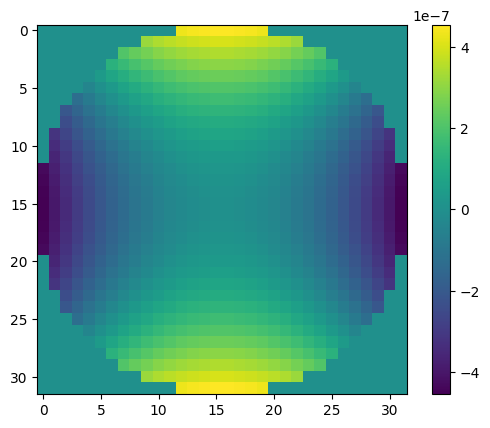

[ 6.4218663e-14 -2.6380589e-14  6.5626432e-14]


In [123]:
new_diversity = Z.Mode(4)*diversity_shift 

estimator = LIFT(keck, Z, new_diversity, 5)

PSF_0 = (cube_mean[10,:,:][ROI])

PSF_0 = np.abs(PSF_0)
# PSF_0 = np.where(PSF_0<0,0,PSF_0)

R_n   = cube_var[10,:,:][ROI]

plt.imshow(R_n)
plt.colorbar()
plt.show()

modes_1 = [0,1,2]

calib_samples = 25

A_matrix = np.zeros((calib_samples,modes_1[-1]+1),dtype=float)

for i in range(calib_samples):

    ##%% Diverity calibration. Here we reconstruct slighly more modes that needed to later use them as a diversity prior. It helps to avoid the cross-talk between modes
    A_1, PSF_1, _ = estimator.Reconstruct(PSF_0, R_n=R_n, mode_ids=modes_1, optimize_norm='sum',verbous=False)

    A_matrix[i] = A_1
    
    print(A_1)
    
    # plt.imshow(PSF_0)
    # plt.colorbar()
    # plt.show()
    
    plt.imshow(np.hstack([PSF_0, PSF_1]))
    plt.show()
    
    print("Expected defocus: {:.1f} [nm]\nMeasured defocus {:.1f} [nm]".format(0, (A_1[2])*1e9))
    
    # A_1[0:2] *= 0 # Remove TT component, it is not needed for the diversity calibration
    # new_diversity = Z.wavefrontFromModes(estimator, A_1) + Z.Mode(4)*diversity_shift # now diversity phase contains defocus. If defocus is biased, diversity absorbs it
    new_diversity += (Z.wavefrontFromModes(estimator, A_1))
    estimator.diversity_OPD = new_diversity
    
    plt.imshow(new_diversity)
    plt.colorbar()
    plt.show()
    
    print(A_1[2])

A_matrix[:,:2] *= 0

print(A_matrix)

A_1_final = A_matrix[-1,:]
print(np.shape(A_1_final))

new_diversity = Z.wavefrontFromModes(estimator, A_1_final) + Z.Mode(4)*diversity_shift

plt.imshow(new_diversity)
plt.colorbar()
plt.show()

modes_1 = [0,1,2]

A_1, PSF_1, _ = estimator.Reconstruct(PSF_0, R_n=R_n, mode_ids=modes_1, optimize_norm='sum',verbous=False)

print(A_1)

In [124]:
defocus_values_LiFT = np.zeros((21,30),dtype=float)
defocus_elongation = np.zeros((21,30),dtype=float)

defocus_values_LiFT_2 = np.zeros(21,dtype=float) # single curve values: mean images used for each defocus offset
defocus_elongation_2  = np.zeros(21,dtype=float) # single curve values: mean images used for each defocus offset

print(modes[-1])

# start timer
start_time = time.time()

for i in range(21):
    
    print("Defocus offset: {} nm rms".format(defocus_values[i]))
    R_n = cube_var[i,:,:][ROI]
    
    for j in range(30):

        PSF_0 = (cube[i,j,:,:])[ROI]

        PSF_0 = np.abs(PSF_0)
        # PSF_0 = np.where(PSF_0<0,0,PSF_0)

        A_1_init = np.array( [0, 0, elongation_def(*fitgaussian(PSF_0)[-2:]) * 1e-9, 0] )   # - k band
        print("Elongation: {}".format(A_1_init[2]))
        defocus_elongation[i,j] = A_1_init[2]*10**9
        
        # A_1, _, _ = estimator.Reconstruct(PSF_0, R_n=R_n, mode_ids=modes, A_0=A_1_init, optimize_norm='sum')
        A_1, _, _ = estimator.Reconstruct(PSF_0, R_n=R_n, mode_ids=modes, A_0=np.zeros(modes[-1]+1,dtype=float), optimize_norm='sum')
        print(A_1[2])
        defocus_values_LiFT[i,j] = A_1[2]*10**9

# End timer
end_time = time.time()
# Calculate elapsed time
elapsed_time = end_time - start_time
print("Elapsed time for SE LiFT with {} pixels in Tel.resolution : {:.5f} seconds".format(keck.pupil.shape[0], elapsed_time))


# single curve tests: using mean images

# start timer
start_time = time.time()

for i in range(21):
    print("Iteration i: {}".format(i))
    print("Defocus offset: {} nm rms".format(defocus_values[i]))
    
    PSF_0 = (cube_mean[i,:,:])[ROI]

    PSF_0 = np.abs(PSF_0)
    # PSF_0 = np.where(PSF_0<0,0,PSF_0)
    
    R_n = cube_var[i,:,:][ROI]

    A_1_init = np.array( [0, 0, elongation_def(*fitgaussian(PSF_0)[-2:]) * 1e-9, 0] )   # - k band
    print(fitgaussian(PSF_0))
    defocus_elongation_2[i] = A_1_init[2]*10**9
    print("Estimated defous (elongation): {}".format(A_1_init[2]*10**9))
    
    # A_1, _, _ = estimator.Reconstruct(PSF_0, R_n=R_n, mode_ids=modes, A_0=A_1_init, optimize_norm='sum')
    A_1, _, _ = estimator.Reconstruct(PSF_0, R_n=R_n, mode_ids=modes, optimize_norm='sum')
    print("Estimeted defocus (LiFT): {}".format(A_1[2]))
    defocus_values_LiFT_2[i] = A_1[2]*10**9

# End timer
end_time = time.time()
# Calculate elapsed time
elapsed_time = end_time - start_time
print("Elapsed time for LE LiFT with {} pixels in Tel.resolution : {:.5f} seconds".format(keck.pupil.shape[0], elapsed_time))

2
Defocus offset: -250 nm rms
Elongation: -2.6881908167927643e-07
-1.6147807e-07
Elongation: -2.621872391494606e-07
-1.5677793e-07
Elongation: -2.709722463756591e-07
-1.7665114e-07
Elongation: -2.676822158667e-07
-1.8125392e-07
Elongation: -2.761730391935009e-07
-1.9021233e-07
Elongation: -2.7192369466260806e-07
-1.820672e-07
Elongation: -2.71134674969724e-07
-1.6487795e-07
Elongation: -2.759611014559202e-07
-1.8097155e-07
Elongation: -2.685144923543438e-07
-1.7205346e-07
Elongation: -2.753024594037565e-07
-1.8019281e-07
Elongation: -2.60542127873618e-07
-1.7176531e-07
Elongation: -2.696473841202678e-07
-1.6751507e-07
Elongation: -2.734316683039768e-07
-1.8438966e-07
Elongation: -2.646768384171291e-07
-1.7364574e-07
Elongation: -2.7244208105965044e-07
-1.8166793e-07
Elongation: -2.73777958653666e-07
-1.92452e-07
Elongation: -2.6657164829374545e-07
-1.7133056e-07
Elongation: -2.61466915730853e-07
-1.8287211e-07
Elongation: -2.738620403499705e-07
-1.89651e-07
Elongation: -2.9614748636780

In [125]:
Keck_results_path = "C:/Users/rafae/OneDrive/Ambiente de Trabalho/Tese/Reports/GS_vs_LiFT/Figures/On_sky_2020/"

[ -5.66902969  -2.35560549  -1.96639149  -3.38067707  -1.16925492
  -3.13257331  -2.65670863  -2.12226325  -0.34324898  -1.49781609
  -1.11120908  -3.60557606  -2.63132627  -3.20097371  -3.00769187
   6.6834005   10.20667639 -52.65424008  33.04104723 -68.31783494
 -39.10187729]


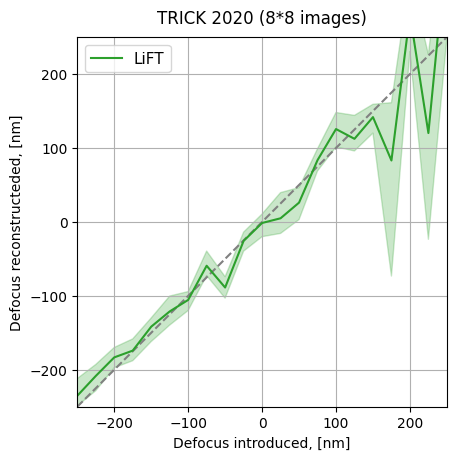

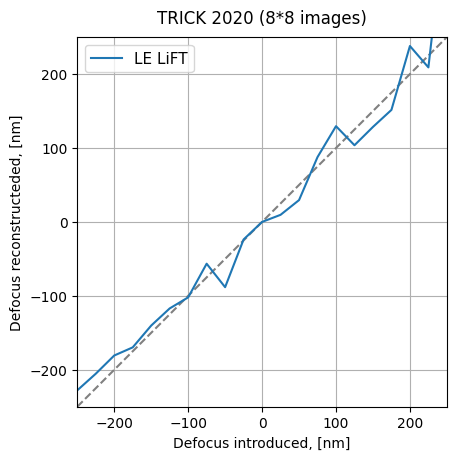

In [126]:
slope_adjust = 1.3
bias_adjust = 0

print(np.median(defocus_values_LiFT,axis=1)-defocus_values_LiFT_2)

# slope_adjust = 1.4
# bias_adjust = -60

save_plots = False

defocus_values_LiFT_c = (defocus_values_LiFT+bias_adjust)*slope_adjust

# print(defocus_values_LiFT_c)

defus = np.median(defocus_values_LiFT_c,axis=1)

p = 95 # Initialize 95% confidence interval 
d_upper = np.percentile(defocus_values_LiFT_c, 100.0-p, axis=1)
d_lower = np.percentile(defocus_values_LiFT_c, p,       axis=1)

e_upper = np.percentile(defocus_values_LiFT_c, 100.0-p, axis=1)
e_lower = np.percentile(defocus_values_LiFT_c, p,       axis=1)

plt.fill_between(defocus_values, d_lower, d_upper, color='tab:green', alpha=0.25)

plt.plot(defocus_values, defocus_values, color='gray', linestyle='--')
plt.plot(defocus_values, defus,   color='tab:green', label='LiFT')
# plt.plot(defocus_values, (defocus_values_LiFT_2+bias_adjust)*slope_adjust, color='tab:blue', label='LE LiFT')
plt.legend(fontsize=11)
plt.grid()
ax = plt.gca()
ax.set_aspect('equal')
plt.xlim([defocus_values.min(), defocus_values.max()])
plt.ylim([defocus_values.min(), defocus_values.max()])
plt.xlabel('Defocus introduced, [nm]')
plt.ylabel('Defocus reconstructeded, [nm]')

if images_8_8 == True:
    plt.title("TRICK 2020 (8*8 images)",pad=10)

else:
    plt.title("TRICK 2020 (4*4 images)",pad=10)

if save_plots:
    if images_8_8 == True:
        plt.savefig(Keck_results_path+"/LiFT_"+"20200108lift_zc4_8x"+'_defocus.png', bbox_inches='tight')
    else:
        plt.savefig(Keck_results_path+"/LiFT_"+"20200108lift_zc4_4x"+'_defocus.png', bbox_inches='tight')
plt.show()


data = np.column_stack((defocus_values, defus))


defocus_values_LiFT_2_c = (defocus_values_LiFT_2+bias_adjust)*slope_adjust

plt.plot(defocus_values, defocus_values, color='gray', linestyle='--')
# plt.plot(defocus_values, defus,   color='tab:green', label='LiFT')
plt.plot(defocus_values, (defocus_values_LiFT_2_c), color='tab:blue', label='LE LiFT')
plt.legend(fontsize=11)
plt.grid()
ax = plt.gca()
ax.set_aspect('equal')
plt.xlim([defocus_values.min(), defocus_values.max()])
plt.ylim([defocus_values.min(), defocus_values.max()])
plt.xlabel('Defocus introduced, [nm]')
plt.ylabel('Defocus reconstructeded, [nm]')

if images_8_8 == True:
    plt.title("TRICK 2020 (8*8 images)",pad=10)

else:
    plt.title("TRICK 2020 (4*4 images)",pad=10)

if save_plots:
    if images_8_8 == True:
        plt.savefig(Keck_results_path+"/LE_LiFT_"+"20200108lift_zc4_8x"+'_defocus.png', bbox_inches='tight')
    else:
        plt.savefig(Keck_results_path+"/LE_LiFT_"+"20200108lift_zc4_4x"+'_defocus.png', bbox_inches='tight')
plt.show()


data = np.column_stack((data, (defocus_values_LiFT_2_c)))

# print(data)

# # save data in SPIE folder
# save_path = f'C:/Users/rafae/OneDrive/Ambiente de Trabalho/Pycharm_projects/FPWFS_master_thesis/Jupyter_notebooks/SPIE_graphs/Data/'
# filename = "On_sky_TRICK_2020_LiFT.txt"

# save_path += filename

# np.savetxt(save_path, data, fmt=f'%.10f', delimiter=',', newline="\n", \
#            header="LiFT: on-sky data; first column: ground-truth; second column - SE LiFT; third column - LE LiFT")

Elongus bias: -174.6754254814919


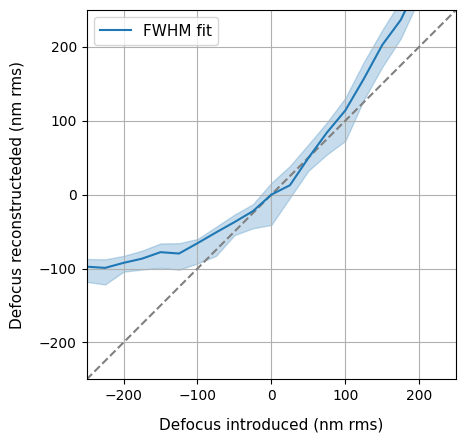

Elongus bias: -177.0535285579884


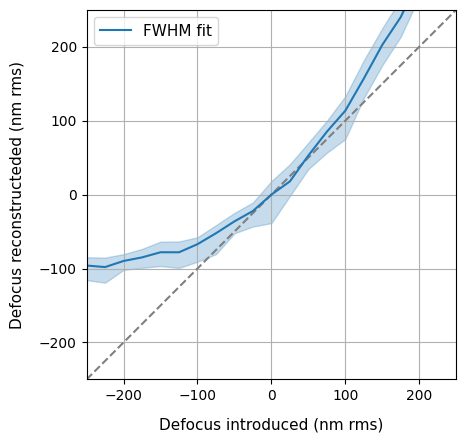

In [127]:
elongus = np.median(defocus_elongation,axis=1)

bias_elongus = elongus[10] # elongation defocus value for in-focus iamges

print("Elongus bias: {}".format(bias_elongus))

p = 95 # Initialize 95% confidence interval 
d_upper = np.percentile(defocus_elongation, 100.0-p, axis=1)
d_lower = np.percentile(defocus_elongation, p,       axis=1)

e_upper = np.percentile(defocus_elongation, 100.0-p, axis=1)
e_lower = np.percentile(defocus_elongation, p,       axis=1)

plt.fill_between(defocus_values, d_lower-bias_elongus, d_upper-bias_elongus, color='tab:blue', alpha=0.25)

plt.plot(defocus_values, defocus_values, color='gray', linestyle='--')
plt.plot(defocus_values, elongus-bias_elongus, color='tab:blue', label='FWHM fit')
plt.legend(fontsize=11)
plt.grid()
ax = plt.gca()
ax.set_aspect('equal')
plt.xlim([defocus_values.min(), defocus_values.max()])
plt.ylim([defocus_values.min(), defocus_values.max()])
plt.xlabel('Defocus introduced (nm rms)',labelpad=10,fontsize=11)
plt.ylabel('Defocus reconstructeded (nm rms)',labelpad=10,fontsize=11)

plt.show()

data = np.column_stack((data, (elongus-bias_elongus)))

################################################################# - Long exposure FWHM fit

elongus = (defocus_elongation_2)

bias_elongus = elongus[10] # elongation defocus value for in-focus iamges

print("Elongus bias: {}".format(bias_elongus))

p = 95 # Initialize 95% confidence interval 
d_upper = np.percentile(defocus_elongation, 100.0-p, axis=1)
d_lower = np.percentile(defocus_elongation, p,       axis=1)

e_upper = np.percentile(defocus_elongation, 100.0-p, axis=1)
e_lower = np.percentile(defocus_elongation, p,       axis=1)

plt.fill_between(defocus_values, d_lower-bias_elongus, d_upper-bias_elongus, color='tab:blue', alpha=0.25)

plt.plot(defocus_values, defocus_values, color='gray', linestyle='--')
plt.plot(defocus_values, elongus-bias_elongus, color='tab:blue', label='FWHM fit')
plt.legend(fontsize=11)
plt.grid()
ax = plt.gca()
ax.set_aspect('equal')
plt.xlim([defocus_values.min(), defocus_values.max()])
plt.ylim([defocus_values.min(), defocus_values.max()])
plt.xlabel('Defocus introduced (nm rms)',labelpad=10,fontsize=11)
plt.ylabel('Defocus reconstructeded (nm rms)',labelpad=10,fontsize=11)

plt.show()

data = np.column_stack((data, (elongus-bias_elongus)))

In [128]:
print(data)

# save data in SPIE folder
save_path = f'C:/Users/rafae/OneDrive/Ambiente de Trabalho/Pycharm_projects/FPWFS_master_thesis/Jupyter_notebooks/SPIE_graphs/Data/'
filename = "On_sky_TRICK_2020_LiFT_FWHM.txt"

save_path += filename

np.savetxt(save_path, data, fmt=f'%.10f', delimiter=',', newline="\n", \
           header="LiFT: on-sky data; first column: ground-truth; second column - SE LiFT; third column - LE LiFT ; fourth column - SE FWHM fit; fifth column - LE FWHM fit")

[[-2.50000000e+02 -2.35203672e+02 -2.27833934e+02 -9.75074624e+01
  -9.59795876e+01]
 [-2.25000000e+02 -2.08418973e+02 -2.05356686e+02 -9.91694777e+01
  -9.80456174e+01]
 [-2.00000000e+02 -1.83265907e+02 -1.80709598e+02 -9.23320503e+01
  -8.97928695e+01]
 [-1.75000000e+02 -1.74110239e+02 -1.69715359e+02 -8.66600550e+01
  -8.49525422e+01]
 [-1.50000000e+02 -1.41721908e+02 -1.40201877e+02 -7.78968731e+01
  -7.79995325e+01]
 [-1.25000000e+02 -1.21103299e+02 -1.17030954e+02 -7.97310280e+01
  -7.80523700e+01]
 [-1.00000000e+02 -1.05525107e+02 -1.02071385e+02 -6.57624802e+01
  -6.70764457e+01]
 [-7.50000000e+01 -5.92957818e+01 -5.65368396e+01 -5.12539530e+01
  -5.22938835e+01]
 [-5.00000000e+01 -8.87304999e+01 -8.82842762e+01 -3.72245401e+01
  -3.62243454e+01]
 [-2.50000000e+01 -2.56924024e+01 -2.37452415e+01 -2.24241339e+01
  -2.21913753e+01]
 [ 0.00000000e+00 -1.44448649e+00  8.53143619e-05  0.00000000e+00
   0.00000000e+00]
 [ 2.50000000e+01  4.92177830e+00  9.60902717e+00  1.26152563e+01